<a href="https://colab.research.google.com/github/Hadjerben03/Auth_Screen_UI_Challenge/blob/master/Vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!rm -rf /content/drive

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Exemple avec le chemin correct vers tes fichiers
images  = np.load("/content/drive/MyDrive/dataset-v2/npy_files/preprocessed_images.npy")
boneage = np.load("/content/drive/MyDrive/dataset-v2/npy_files/labels_boneage.npy")
sex     = np.load("/content/drive/MyDrive/dataset-v2/npy_files/labels_sex.npy")

print(images.shape, boneage.shape, sex.shape)

# Vérification des shapes (utile pour debugging)
print(f"Images: {images.shape}, Boneage: {boneage.shape}, Sex: {sex.shape}")


X_train_img, X_val_img, y_train_age, y_val_age, sex_train, sex_val = train_test_split(
    images, boneage, sex, test_size=0.2, random_state=42
)


(12564, 224, 224, 1) (12564,) (12564,)
Images: (12564, 224, 224, 1), Boneage: (12564,), Sex: (12564,)


In [ ]:
np.save("/content/drive/MyDrive/dataset-v2/npy_files/X_train.npy", X_train_img)
np.save("/content/drive/MyDrive/dataset-v2/npy_files/X_val.npy", X_val_img)
np.save("/content/drive/MyDrive/dataset-v2/npy_files/y_train_age.npy", y_train_age)
np.save("/content/drive/MyDrive/dataset-v2/npy_files/y_val_age.npy", y_val_age)
np.save("/content/drive/MyDrive/dataset-v2/npy_files/sex_train.npy", sex_train)
np.save("/content/drive/MyDrive/dataset-v2/npy_files/sex_val.npy", sex_val)


In [ ]:
# 1. Imports nécessaires
import os
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.applications import VGG16, EfficientNetB0
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random

In [ ]:
X_train = np.load("/content/drive/MyDrive/dataset-v2/npy_files/X_train.npy")
X_val = np.load("/content/drive/MyDrive/dataset-v2/npy_files/X_val.npy")
y_train = np.load("/content/drive/MyDrive/dataset-v2/npy_files/y_train_age.npy")
y_val = np.load("/content/drive/MyDrive/dataset-v2/npy_files/y_val_age.npy")
sex_train = np.load("/content/drive/MyDrive/dataset-v2/npy_files/sex_train.npy")
sex_val = np.load("/content/drive/MyDrive/dataset-v2/npy_files/sex_val.npy")


In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np
from tensorflow.keras.applications import vgg16

class RGBPreprocessingGenerator(Sequence):
    def __init__(self, X, sex, y, batch_size=32, model_type="vgg", shuffle=True):
        self.X = X
        self.sex = sex
        self.y = y
        self.batch_size = batch_size
        self.model_type = model_type
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.X))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = self.X[batch_indexes]
        sex_batch = self.sex[batch_indexes]
        y_batch = self.y[batch_indexes]

        # Si les images sont en niveaux de gris (1 canal), les convertir en RGB
        if X_batch.shape[-1] == 1:  # Vérifie si le dernier axe est de taille 1 (grayscale)
            X_batch_rgb = np.repeat(X_batch, 3, axis=-1)  # Convertir en RGB sans ajouter de dimension supplémentaire
        else:
            X_batch_rgb = X_batch  # Si déjà en RGB, ne rien changer

        if self.model_type == "vgg":
            X_batch_rgb = vgg16.preprocess_input(X_batch_rgb.astype(np.float32))

        return {"image_input": X_batch_rgb, "sex_input": sex_batch}, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)



In [ ]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import VGG16

def create_vgg16_with_sex_input():
    # Entrée image (après ImageDataGenerator en RGB 224x224)
    img_input = Input(shape=(224, 224, 3), name="image_input")

    # VGG16 (sans les couches fully connected finales)
    base_model = VGG16(include_top=False, input_tensor=img_input, weights='imagenet')
    base_model.trainable = False  # Freeze le VGG

    # Sortie du VGG16
    x = base_model.output
    x = layers.Flatten()(x)

    # Entrée sexe (0 pour fille, 1 pour garçon)
    sex_input = Input(shape=(1,), name="sex_input")

    # Fusion image + sexe
    x = layers.Concatenate()([x, sex_input])

    # Couches fully connected
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    output = layers.Dense(1, name="boneage_output")(x)  # Régression d'âge osseux

    # Modèle final
    model = models.Model(inputs=[img_input, sex_input], outputs=output)
    return model

# Crée le modèle
vgg_model = create_vgg16_with_sex_input()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Préparation des générateurs
train_generator = RGBPreprocessingGenerator(X_train, sex_train, y_train_age, model_type="vgg")
val_generator = RGBPreprocessingGenerator(X_val, sex_val, y_val_age, model_type="vgg")


In [ ]:
checkpoint = ModelCheckpoint(
    "best_model_vgg.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)



In [ ]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model


vgg_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='mse',
                  metrics=['mae', 'mse'])

history = vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,  # augmente plus tard si tout va bien
    callbacks=[checkpoint]
)


Epoch 1/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 6.3271e-07 - loss: -1970.5359 
Epoch 1: val_loss improved from inf to -2026.41467, saving model to best_model_vgg.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 6833s 22s/step - accuracy: 9.4556e-07 - loss: -1970.6338 - val_accuracy: 0.0000e+00 - val_loss: -2026.4147
Epoch 2/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 1.4478e-04 - loss: -2010.4537 
Epoch 2: val_loss improved from -2026.41467 to -2026.41504, saving model to best_model_vgg.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 6809s 22s/step - accuracy: 1.4464e-04 - loss: -2010.4498 - val_accuracy: 0.0000e+00 - val_loss: -2026.4150
Epoch 3/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 7.7118e-05 - loss: -2003.2338 
Epoch 3: val_loss did not improve from -2026.41504
315/315 ━━━━━━━━━━━━━━━━━━━━ 6773s 21s/step - accuracy: 7.7189e-05 - loss: -2003.2527 - val_accuracy: 0.0000e+00 - val_loss: -2026.4150
Epoch 4/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 2.6604e-05 - loss: -2008.9060 
Epoch 4: val_loss did not improve from -2026.41504
315/315 ━━━━━━━━━━━━━━━━━━━━ 6763s 21s/step - accuracy: 2.6835e-05 - loss: -2008.9070 - val_accuracy: 0.0000e+00 - val_loss: -2026.4144
Epoch 5/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 4.4663e-04 - loss: -2012.4196 
Epoch 5: val_loss did not improve from -2026.41504
315/315 ━━━━━━━━━━━━━━━━━━━━ 6789s 22s/step - accuracy: 4.4553e-04 - loss: -2012.4094 - val_accuracy: 0.0000e+00 - val_loss: -2026.4147


In [ ]:
import pandas as pd

# Convertir l'history en DataFrame
history_df = pd.DataFrame(history.history)

# Sauvegarder dans un fichier CSV
history_df.to_csv('training_history.csv', index=False)

# Sauvegarder le modèle (avec architecture + poids)
vgg_model.save("modele_5_epochs.keras")  # ou .h5



In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset-v2/training_history.csv')
print(df[['accuracy', 'val_accuracy']])


   accuracy  val_accuracy
0  0.000099           0.0
1  0.000099           0.0
2  0.000099           0.0
3  0.000099           0.0
4  0.000099           0.0


In [ ]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

# === 1. Charger le modèle enregistré à l’epoch 5 ===
model = load_model("/content/drive/MyDrive/dataset-v2/modele_5_epochs.keras")  # assure-toi que ce fichier existe bien

# === 2. (Facultatif) Recompiler le modèle ===
# Cela est nécessaire seulement si le modèle a été sauvegardé sans les informations de compilation
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
)

# === 3. Callback pour sauvegarder les modèles suivants ===
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/dataset-v2/modele_5_epochs.keras',
    save_freq='epoch',
    save_weights_only=False,
    save_best_only=False
)

# === 4. Reprendre l'entraînement depuis l'epoch 5 jusqu’à 50 ===
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    initial_epoch=5,  # 👈 très important
    callbacks=[checkpoint]
)
import pandas as pd

# Convertir l'history en DataFrame
history_df = pd.DataFrame(history.history)

# Sauvegarder dans un fichier CSV
history_df.to_csv('training_history_2.csv', index=False)

# Sauvegarder le modèle (avec architecture + poids)
vgg_model.save("modele_10_epochs.keras")  # ou .h5


Epoch 6/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


315/315 ━━━━━━━━━━━━━━━━━━━━ 84s 226ms/step - loss: 3857.8689 - mae: 43.0717 - val_loss: 4140.5498 - val_mae: 56.1523
Epoch 7/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 65s 206ms/step - loss: 1161.7648 - mae: 26.9796 - val_loss: 4198.3398 - val_mae: 57.2962
Epoch 8/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 65s 207ms/step - loss: 905.2238 - mae: 23.9239 - val_loss: 4442.0308 - val_mae: 59.1325
Epoch 9/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 83s 209ms/step - loss: 782.9818 - mae: 21.9903 - val_loss: 3894.6211 - val_mae: 55.3140
Epoch 10/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 65s 207ms/step - loss: 696.9660 - mae: 20.5377 - val_loss: 4749.1245 - val_mae: 61.9559


In [ ]:
import pandas as pd

# Convertir l'history en DataFrame
history_df = pd.DataFrame(history.history)

# Sauvegarder dans un fichier CSV
history_df.to_csv('training_history_2.csv', index=False)

# Sauvegarder le modèle (avec architecture + poids)
vgg_model.save("modele_10_epochs.keras")  # ou .h5

In [ ]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

# === 1. Charger le modèle enregistré à l’epoch 5 ===
model = load_model("/content/drive/MyDrive/dataset-v2/modele_5_epochs.keras")  # assure-toi que ce fichier existe bien

# === 2. (Facultatif) Recompiler le modèle ===
# Cela est nécessaire seulement si le modèle a été sauvegardé sans les informations de compilation
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
)

# === 3. Callback pour sauvegarder les modèles suivants ===
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/dataset-v2/modele_5_epochs.keras',
    save_freq='epoch',
    save_weights_only=False,
    save_best_only=False
)

# === 4. Reprendre l'entraînement depuis l'epoch 5 jusqu’à 50 ===
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    initial_epoch=10,  # 👈 très important
    callbacks=[checkpoint]
)


Epoch 11/25
315/315 ━━━━━━━━━━━━━━━━━━━━ 67s 203ms/step - loss: 724.7188 - mae: 21.1873 - val_loss: 4454.0332 - val_mae: 59.6964
Epoch 12/25
315/315 ━━━━━━━━━━━━━━━━━━━━ 73s 233ms/step - loss: 610.3964 - mae: 19.2497 - val_loss: 4543.1372 - val_mae: 60.4067
Epoch 13/25
315/315 ━━━━━━━━━━━━━━━━━━━━ 66s 208ms/step - loss: 566.0131 - mae: 18.3898 - val_loss: 4674.9072 - val_mae: 61.5239
Epoch 14/25
315/315 ━━━━━━━━━━━━━━━━━━━━ 82s 209ms/step - loss: 518.5739 - mae: 17.8181 - val_loss: 4145.8218 - val_mae: 57.5748
Epoch 15/25
315/315 ━━━━━━━━━━━━━━━━━━━━ 65s 206ms/step - loss: 471.6972 - mae: 16.9388 - val_loss: 4254.9067 - val_mae: 58.4107
Epoch 16/25
315/315 ━━━━━━━━━━━━━━━━━━━━ 65s 207ms/step - loss: 503.4879 - mae: 16.9919 - val_loss: 4050.5027 - val_mae: 56.7499
Epoch 17/25
315/315 ━━━━━━━━━━━━━━━━━━━━ 65s 207ms/step - loss: 427.7093 - mae: 16.1228 - val_loss: 3923.3208 - val_mae: 55.6238
Epoch 18/25
315/315 ━━━━━━━━━━━━━━━━━━━━ 90s 234ms/step - loss: 440.5868 - mae: 15.7001 - val_los

In [ ]:
import pandas as pd

# Convertir l'history en DataFrame
history_df = pd.DataFrame(history.history)

# Sauvegarder dans un fichier CSV
history_df.to_csv('training_history_3.csv', index=False)

# Sauvegarder le modèle (avec architecture + poids)
vgg_model.save("modele_25_epochs.keras")  # ou .h5

Clés disponibles dans l'historique : dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


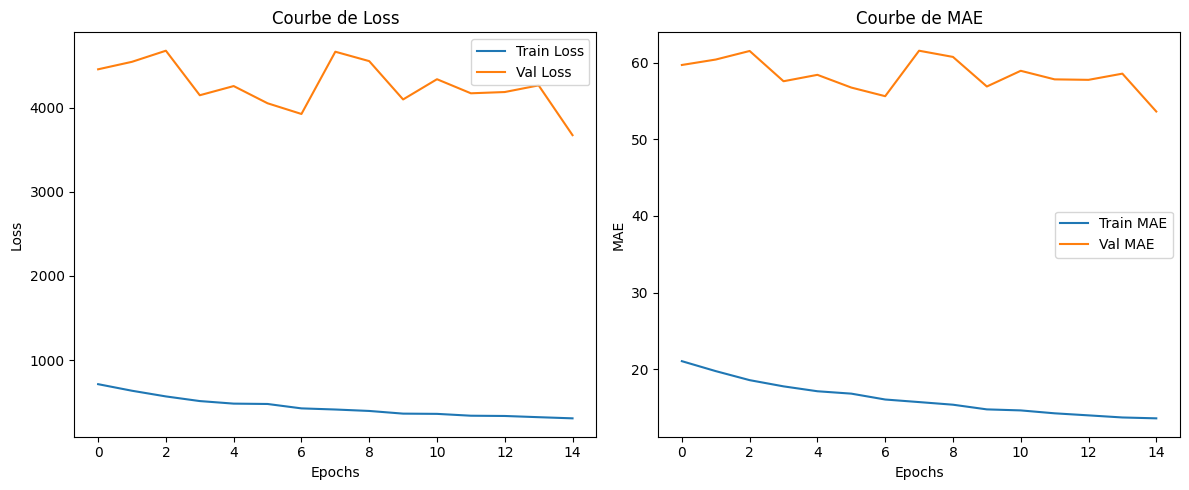

In [ ]:
import matplotlib.pyplot as plt

# === 1. Récupérer l'historique ===
history_dict = history.history

# === 2. Affichage des clés disponibles dans l'historique ===
print("Clés disponibles dans l'historique :", history_dict.keys())

# === 3. Tracer la loss ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbe de Loss')
plt.legend()

# === 4. Tracer le MAE (Mean Absolute Error) ===
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Courbe de MAE')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 11/25
315/315 ━━━━━━━━━━━━━━━━━━━━ 70s 213ms/step - loss: 310.2184 - mae: 13.5094 - mse: 310.2184 - val_loss: 4726.8545 - val_mae: 62.0441 - val_mse: 4726.8545
Epoch 12/25
315/315 ━━━━━━━━━━━━━━━━━━━━ 64s 203ms/step - loss: 303.2631 - mae: 13.2478 - mse: 303.2631 - val_loss: 4193.4639 - val_mae: 57.9422 - val_mse: 4193.4639
Epoch 13/25
315/315 ━━━━━━━━━━━━━━━━━━━━ 64s 205ms/step - loss: 286.7666 - mae: 12.9903 - mse: 286.7666 - val_loss: 4174.9775 - val_mae: 57.8055 - val_mse: 4174.9775
Epoch 14/25
315/315 ━━━━━━━━━━━━━━━━━━━━ 64s 204ms/step - loss: 282.3078 - mae: 12.8271 - mse: 282.3078 - val_loss: 4015.9065 - val_mae: 56.4928 - val_mse: 4015.9065
Epoch 15/25
315/315 ━━━━━━━━━━━━━━━━━━━━ 64s 203ms/step - loss: 251.1814 - mae: 12.1933 - mse: 251.1814 - val_loss: 4248.2969 - val_mae: 58.3079 - val_mse: 4248.2969
Epoch 16/25
315/315 ━━━━━━━━━━━━━━━━━━━━ 64s 204ms/step - loss: 257.3625 - mae: 12.3290 - mse: 257.3625 - val_loss: 4133.6479 - val_mae: 57.4048 - val_mse: 4133.6479
Epoc

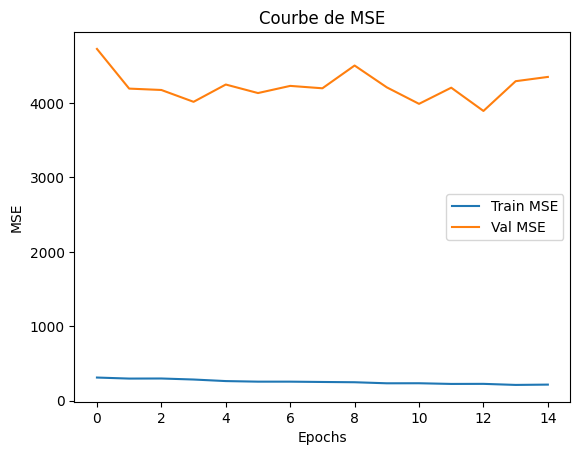

In [ ]:
import matplotlib.pyplot as plt

# Compilation
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae', 'mse']
)

# Entraînement
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    initial_epoch=10
)

# Affichage des clés dispo
print("Clés disponibles :", history.history.keys())

# Tracer les courbes si les clés existent
history_dict = history.history
if 'mse' in history_dict:
    plt.figure()
    plt.plot(history_dict['mse'], label='Train MSE')
    plt.plot(history_dict['val_mse'], label='Val MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.title('Courbe de MSE')
    plt.legend()
    plt.show()
else:
    print("⚠️ Les clés 'mse' et 'val_mse' ne sont pas présentes.")


In [ ]:
def __getitem__(self, index):
    batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
    X_batch = self.X[batch_indexes]
    sex_batch = self.sex[batch_indexes]
    y_batch = self.y[batch_indexes]

    # 🛠 Assurer que les images ont bien 4 dimensions
    if X_batch.ndim == 3:  # (batch_size, height, width)
        X_batch = np.expand_dims(X_batch, -1)  # devient (batch_size, height, width, 1)

    # Si les images sont en niveaux de gris (1 canal), les convertir en RGB
    if X_batch.shape[-1] == 1:
        X_batch_rgb = np.repeat(X_batch, 3, axis=-1)  # devient (batch_size, height, width, 3)
    else:
        X_batch_rgb = X_batch  # déjà en RGB

    # Prétraitement VGG
    if self.model_type == "vgg":
        X_batch_rgb = vgg16.preprocess_input(X_batch_rgb.astype(np.float32))

    return {"image_input": X_batch_rgb, "sex_input": sex_batch}, y_batch


In [ ]:
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.vgg16 import preprocess_input

class SimpleDataGenerator(Sequence):
    def __init__(self, X, sex, y, batch_size=32, shuffle=True):
        self.X = X
        self.sex = sex
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(X))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        batch_idx = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = self.X[batch_idx]
        sex_batch = self.sex[batch_idx]
        y_batch = self.y[batch_idx]

        # Assurer que les images ont un canal
        if X_batch.ndim == 3:  # (batch, height, width)
            X_batch = np.expand_dims(X_batch, -1)

        # Convertir en RGB si grayscale (1 canal)
        if X_batch.shape[-1] == 1:
            X_batch = np.repeat(X_batch, 3, axis=-1)

        # Redimensionner si les images ne sont pas 224x224
        if X_batch.shape[1:3] != (224, 224):
            import tensorflow as tf
            X_batch = tf.image.resize(X_batch, (224, 224)).numpy()

        # Prétraitement VGG
        X_batch = preprocess_input(X_batch.astype(np.float32))

        return {"image_input": X_batch, "sex_input": sex_batch}, y_batch


In [ ]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import VGG16

def create_vgg16_with_sex_input():
    img_input = Input(shape=(224, 224, 3), name="image_input")
    base_model = VGG16(include_top=False, input_tensor=img_input, weights='imagenet')
    base_model.trainable = False

    x = base_model.output
    x = layers.Flatten()(x)

    sex_input = Input(shape=(1,), name="sex_input")
    x = layers.Concatenate()([x, sex_input])

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, name="boneage_output")(x)

    return models.Model(inputs=[img_input, sex_input], outputs=output)


In [ ]:
import pandas as pd

# Création des générateurs
train_gen = SimpleDataGenerator(X_train, sex_train, y_train, batch_size=32)
val_gen = SimpleDataGenerator(X_val, sex_val, y_val, batch_size=32)

# Création et compilation du modèle
model = create_vgg16_with_sex_input()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Entraînement
model.fit(train_gen, validation_data=val_gen, epochs=10)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


315/315 ━━━━━━━━━━━━━━━━━━━━ 89s 239ms/step - loss: 4777.7656 - mae: 49.8979 - val_loss: 1159.5406 - val_mae: 27.1878
Epoch 2/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 67s 212ms/step - loss: 1617.9221 - mae: 31.8917 - val_loss: 993.0273 - val_mae: 25.0349
Epoch 3/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 83s 215ms/step - loss: 1380.2119 - mae: 29.4556 - val_loss: 1091.6515 - val_mae: 26.5695
Epoch 4/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 66s 210ms/step - loss: 1301.0472 - mae: 28.5389 - val_loss: 890.3702 - val_mae: 23.6344
Epoch 5/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 66s 211ms/step - loss: 1200.3468 - mae: 27.3483 - val_loss: 911.2312 - val_mae: 24.0009
Epoch 6/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 67s 211ms/step - loss: 1118.5786 - mae: 26.2441 - val_loss: 906.9199 - val_mae: 23.6204
Epoch 7/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 66s 210ms/step - loss: 1105.4785 - mae: 26.3705 - val_loss: 963.0163 - val_mae: 24.8093
Epoch 8/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 73s 233ms/step - loss: 1067.4751 - mae: 25.8935 - val_loss: 927.9630 - va

NameError: name 'history' is not defined

In [ ]:
model.save("bone_age_model_v2.h5")


In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

model.fit(train_gen, validation_data=val_gen, epochs=30, callbacks=[early_stop])


Epoch 1/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 68s 214ms/step - loss: 987.1363 - mae: 24.7392 - val_loss: 980.7655 - val_mae: 24.8752
Epoch 2/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 67s 212ms/step - loss: 1011.7796 - mae: 25.1587 - val_loss: 952.0410 - val_mae: 24.4173
Epoch 3/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 74s 234ms/step - loss: 990.0218 - mae: 24.6505 - val_loss: 1032.6506 - val_mae: 25.5451
Epoch 4/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 67s 212ms/step - loss: 986.5960 - mae: 24.8087 - val_loss: 1064.0112 - val_mae: 25.8511
Epoch 5/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 66s 211ms/step - loss: 945.9680 - mae: 24.1284 - val_loss: 913.4373 - val_mae: 23.7424
Epoch 6/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 74s 234ms/step - loss: 937.9149 - mae: 24.0645 - val_loss: 865.7515 - val_mae: 23.0591
Epoch 7/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 67s 212ms/step - loss: 936.5684 - mae: 24.2782 - val_loss: 883.0210 - val_mae: 23.2699
Epoch 8/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 66s 211ms/step - loss: 907.1339 - mae: 23.6715 - val_loss: 929.8394 

In [ ]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# 1. Débloquer certaines couches de VGG16 (ici les 4 derniers blocs conv)
# Tu peux choisir à partir de quel layer tu veux commencer à entraîner
for layer in model.layers:
    if 'block5' in layer.name or 'block4' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

# 2. Recompiler le modèle avec un learning rate plus petit
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Plus petit que 1e-4 pour éviter de casser les poids pré-entraînés
    loss='mse',
    metrics=['mae', 'mse']
)

# 3. Reprendre l'entraînement avec les générateurs
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # tu peux augmenter
    callbacks=[checkpoint]
)


Epoch 1/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 984.8557 - mae: 24.7151 - mse: 984.8557
Epoch 1: val_loss improved from inf to 1045.16418, saving model to best_model_vgg.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 117s 323ms/step - loss: 984.8430 - mae: 24.7150 - mse: 984.8430 - val_loss: 1045.1642 - val_mae: 25.7995 - val_mse: 1045.1642
Epoch 2/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 904.7253 - mae: 23.5979 - mse: 904.7253
Epoch 2: val_loss improved from 1045.16418 to 920.51624, saving model to best_model_vgg.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 132s 331ms/step - loss: 904.7221 - mae: 23.5977 - mse: 904.7221 - val_loss: 920.5162 - val_mae: 24.2390 - val_mse: 920.5162
Epoch 3/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 795.5776 - mae: 22.1150 - mse: 795.5776
Epoch 3: val_loss improved from 920.51624 to 718.54358, saving model to best_model_vgg.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 104s 330ms/step - loss: 795.6157 - mae: 22.1152 - mse: 795.6157 - val_loss: 718.5436 - val_mae: 20.8430 - val_mse: 718.5436
Epoch 4/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 815.1624 - mae: 22.5268 - mse: 815.1624
Epoch 4: val_loss did not improve from 718.54358
315/315 ━━━━━━━━━━━━━━━━━━━━ 96s 305ms/step - loss: 815.1127 - mae: 22.5256 - mse: 815.1127 - val_loss: 833.1057 - val_mae: 22.7399 - val_mse: 833.1057
Epoch 5/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 778.0175 - mae: 21.8101 - mse: 778.0175
Epoch 5: val_loss improved from 718.54358 to 699.55811, saving model to best_model_vgg.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 143s 307ms/step - loss: 777.9567 - mae: 21.8096 - mse: 777.9567 - val_loss: 699.5581 - val_mae: 20.6062 - val_mse: 699.5581
Epoch 6/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 747.1719 - mae: 21.2078 - mse: 747.1719
Epoch 6: val_loss did not improve from 699.55811
315/315 ━━━━━━━━━━━━━━━━━━━━ 96s 305ms/step - loss: 747.1494 - mae: 21.2078 - mse: 747.1494 - val_loss: 711.1707 - val_mae: 20.8440 - val_mse: 711.1707
Epoch 7/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 734.5713 - mae: 20.9969 - mse: 734.5713
Epoch 7: val_loss improved from 699.55811 to 678.69934, saving model to best_model_vgg.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 104s 329ms/step - loss: 734.5853 - mae: 20.9971 - mse: 734.5853 - val_loss: 678.6993 - val_mae: 20.5074 - val_mse: 678.6993
Epoch 8/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 674.0944 - mae: 20.1304 - mse: 674.0944
Epoch 8: val_loss did not improve from 678.69934
315/315 ━━━━━━━━━━━━━━━━━━━━ 96s 304ms/step - loss: 674.1928 - mae: 20.1319 - mse: 674.1928 - val_loss: 882.7784 - val_mae: 23.7462 - val_mse: 882.7784
Epoch 9/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 700.8603 - mae: 20.6692 - mse: 700.8603
Epoch 9: val_loss improved from 678.69934 to 641.40649, saving model to best_model_vgg.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 97s 307ms/step - loss: 700.8639 - mae: 20.6692 - mse: 700.8639 - val_loss: 641.4065 - val_mae: 19.5305 - val_mse: 641.4065
Epoch 10/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 668.5505 - mae: 20.0935 - mse: 668.5505
Epoch 10: val_loss did not improve from 641.40649
315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 306ms/step - loss: 668.5476 - mae: 20.0935 - mse: 668.5476 - val_loss: 705.6285 - val_mae: 20.7984 - val_mse: 705.6285


In [ ]:
!free -h  # Affiche l'utilisation actuelle de la mémoire

               total        used        free      shared  buff/cache   available
Mem:            12Gi       1.1Gi        10Gi       2.0Mi       836Mi        11Gi
Swap:             0B          0B          0B


In [ ]:
import numpy as np
import os
import gc
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence

# 📁 Charger les données de validation
x_val = np.load('/content/drive/MyDrive/dataset-v2/npy_files/X_val.npy') / 255.0
y_val = np.load('/content/drive/MyDrive/dataset-v2/npy_files/y_val_age.npy')

# Convertir les données de validation de grayscale en RGB
x_val_rgb = np.repeat(x_val, 3, axis=-1)

# 📂 Data Generator pour charger les données par lot
class DataGenerator(Sequence):
    def __init__(self, x_path, y_path, batch_size, part_idx, total_parts):
        self.x_path = x_path
        self.y_path = y_path
        self.batch_size = batch_size
        self.part_idx = part_idx
        self.total_parts = total_parts
        self.x, self.y = self.load_data_slice()  # Charger la portion de données

    def load_data_slice(self):
        x = np.load(self.x_path)
        y = np.load(self.y_path)

        total_len = len(x)
        part_size = total_len // self.total_parts
        start = self.part_idx * part_size
        end = (self.part_idx + 1) * part_size if self.part_idx < self.total_parts - 1 else total_len

        return x[start:end], y[start:end]

    def __len__(self):
        # Nombre de batches par epoch
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, idx):
        # Charger un batch
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Normaliser et convertir en RGB
        batch_x = batch_x / 255.0
        batch_x = np.repeat(batch_x, 3, axis=-1)

        return batch_x, batch_y

# 🧠 Construire le modèle basé sur VGG16
def build_model():
    base = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    for layer in base.layers:
        layer.trainable = False  # On fige les couches de base

    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(1)(x)  # Prédiction de l'âge

    model = Model(inputs=base.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
    return model

model = build_model()

# ⚙️ Paramètres d'entraînement
BATCH_SIZE = 32
EPOCHS = 10
PARTS = 5  # 5 x 20% = 100%

# 📁 Créer un dossier pour les checkpoints
checkpoint_dir = '/content/drive/MyDrive/dataset-v2/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# 📊 Journal pour MAE/MSE
results = []

for i in range(PARTS):
    print(f"\n🚀 Entraînement sur le segment {i+1}/{PARTS}")

    # Créer un générateur pour la partie des données
    train_generator = DataGenerator(
        x_path='/content/drive/MyDrive/dataset-v2/npy_files/X_train.npy',
        y_path='/content/drive/MyDrive/dataset-v2/npy_files/y_train_age.npy',
        batch_size=BATCH_SIZE,
        part_idx=i,
        total_parts=PARTS
    )

    checkpoint_path = f"{checkpoint_dir}/model_part_{i+1}.h5"

    callbacks = [
        EarlyStopping(patience=3, restore_best_weights=True),
        ReduceLROnPlateau(patience=2, factor=0.5, verbose=1),
        ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss', verbose=1)
    ]

    # Entraîner le modèle avec le générateur
    model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=(x_val_rgb, y_val),
        callbacks=callbacks,
        verbose=2
    )

    # 📈 Évaluation sur x_val
    predictions = model.predict(x_val_rgb)
    mae = mean_absolute_error(y_val, predictions)
    mse = mean_squared_error(y_val, predictions)
    print(f"\n📊 [Partie {i+1}] MAE: {mae:.4f} | MSE: {mse:.4f}")
    results.append((i+1, mae, mse))

    # 🧹 Nettoyage mémoire
    gc.collect()

# 💾 Sauvegarder les résultats dans un CSV
df = pd.DataFrame(results, columns=["Partie", "MAE", "MSE"])
df.to_csv('/content/drive/MyDrive/dataset-v2/results_log.csv', index=False)


🚀 Entraînement sur le segment 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_22']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)



Epoch 1: val_loss improved from inf to 17390.63086, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_1.h5


63/63 - 2507s - 40s/step - loss: 17567.8340 - mae: 126.0781 - val_loss: 17390.6309 - val_mae: 125.0658 - learning_rate: 1.0000e-04
Epoch 2/10

Epoch 2: val_loss improved from 17390.63086 to 16640.27734, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_1.h5


63/63 - 2484s - 39s/step - loss: 16782.3320 - mae: 122.9393 - val_loss: 16640.2773 - val_mae: 122.0343 - learning_rate: 1.0000e-04
Epoch 3/10

Epoch 3: val_loss improved from 16640.27734 to 15889.37695, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_1.h5


63/63 - 2537s - 40s/step - loss: 16033.7686 - mae: 119.8644 - val_loss: 15889.3770 - val_mae: 118.9247 - learning_rate: 1.0000e-04
Epoch 4/10

Epoch 4: val_loss improved from 15889.37695 to 15056.40918, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_1.h5


63/63 - 2493s - 40s/step - loss: 15255.9492 - mae: 116.5818 - val_loss: 15056.4092 - val_mae: 115.3814 - learning_rate: 1.0000e-04
Epoch 5/10

Epoch 5: val_loss improved from 15056.40918 to 14159.13574, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_1.h5


63/63 - 2489s - 40s/step - loss: 14385.9678 - mae: 112.8013 - val_loss: 14159.1357 - val_mae: 111.4504 - learning_rate: 1.0000e-04
Epoch 6/10

Epoch 6: val_loss improved from 14159.13574 to 13224.00293, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_1.h5


63/63 - 2484s - 39s/step - loss: 13471.7529 - mae: 108.7159 - val_loss: 13224.0029 - val_mae: 107.2096 - learning_rate: 1.0000e-04
Epoch 7/10

Epoch 7: val_loss improved from 13224.00293 to 12262.55664, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_1.h5


63/63 - 2494s - 40s/step - loss: 12525.4033 - mae: 104.3593 - val_loss: 12262.5566 - val_mae: 102.7061 - learning_rate: 1.0000e-04
Epoch 8/10

Epoch 8: val_loss improved from 12262.55664 to 11287.23145, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_1.h5


63/63 - 2485s - 39s/step - loss: 11560.0391 - mae: 99.7088 - val_loss: 11287.2314 - val_mae: 97.9906 - learning_rate: 1.0000e-04
Epoch 9/10

Epoch 9: val_loss improved from 11287.23145 to 10316.11328, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_1.h5


63/63 - 2484s - 39s/step - loss: 10589.6885 - mae: 94.8842 - val_loss: 10316.1133 - val_mae: 93.0975 - learning_rate: 1.0000e-04
Epoch 10/10

Epoch 10: val_loss improved from 10316.11328 to 9355.88672, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_1.h5


63/63 - 2485s - 39s/step - loss: 9624.4043 - mae: 89.8750 - val_loss: 9355.8867 - val_mae: 88.0782 - learning_rate: 1.0000e-04


In [28]:
import gc
gc.collect()

0

In [9]:
import numpy as np
import os
import gc
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Modified Data Generator
class DataGeneratorWithSex:
    def __init__(self, x_path, y_age_path, y_sex_path, batch_size, part_idx, total_parts):
        self.x_path = x_path
        self.y_age_path = y_age_path
        self.y_sex_path = y_sex_path
        self.batch_size = batch_size
        self.part_idx = part_idx
        self.total_parts = total_parts
        self.x, self.y_age, self.y_sex = self.load_data_slice()

    def load_data_slice(self):
        x = np.load(self.x_path)
        y_age = np.load(self.y_age_path)
        y_sex = np.load(self.y_sex_path)

        total_len = len(x)
        part_size = total_len // self.total_parts
        start = self.part_idx * part_size
        end = (self.part_idx + 1) * part_size if self.part_idx < self.total_parts - 1 else total_len

        return x[start:end], y_age[start:end], y_sex[start:end]

    def create_tf_dataset(self):
        # Prepare data
        x = self.x / 255.0
        x = np.repeat(x, 3, axis=-1).astype(np.float32)  # Convert to RGB

        y_sex = self.y_sex.astype(np.float32)
        y_sex = np.expand_dims(y_sex, axis=-1)

        y_age = self.y_age.astype(np.float32)

        # Create dataset directly from numpy arrays
        dataset = tf.data.Dataset.from_tensor_slices(
            (
                {
                    "image_input": x,
                    "sex_input": y_sex
                },
                y_age
            )
        )

        # Batch the dataset
        dataset = dataset.batch(self.batch_size)

        # Prefetch for better performance
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

# Model with Sex Input (unchanged)
def build_model_with_sex_input():
    # Image input
    image_input = Input(shape=(224, 224, 3), name="image_input")
    base = VGG16(weights='imagenet', include_top=False, input_tensor=image_input)
    for layer in base.layers:
        layer.trainable = False  # Freeze base layers for transfer learning

    x = base.output
    x = GlobalAveragePooling2D()(x)

    # Sex input
    sex_input = Input(shape=(1,), name="sex_input")

    # Combine both inputs
    combined = Concatenate()([x, sex_input])
    combined = Dense(128, activation='relu')(combined)
    output = Dense(1)(combined)  # Predict age

    model = Model(inputs=[image_input, sex_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
    return model

# Training setup
BATCH_SIZE = 32
EPOCHS = 10
PARTS = 5  # 5 segments (20% each)

# Checkpoints directory
checkpoint_dir = '/content/drive/MyDrive/dataset-v2/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Create the model
model = build_model_with_sex_input()

# Create data generator for training
train_generator = DataGeneratorWithSex(
    x_path='/content/drive/MyDrive/dataset-v2/npy_files/X_train.npy',
    y_age_path='/content/drive/MyDrive/dataset-v2/npy_files/y_train_age.npy',
    y_sex_path='/content/drive/MyDrive/dataset-v2/npy_files/sex_train.npy',
    batch_size=BATCH_SIZE,
    part_idx=1,  # Second segment
    total_parts=PARTS
)

# Create TF dataset
train_dataset = train_generator.create_tf_dataset()

# Prepare validation data
x_val = np.load('/content/drive/MyDrive/dataset-v2/npy_files/X_val.npy') / 255.0
y_val_age = np.load('/content/drive/MyDrive/dataset-v2/npy_files/y_val_age.npy')
y_val_sex = np.load('/content/drive/MyDrive/dataset-v2/npy_files/sex_val.npy')
x_val_rgb = np.repeat(x_val, 3, axis=-1).astype(np.float32)
y_val_sex = np.expand_dims(y_val_sex, axis=-1).astype(np.float32)

# Training Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5, verbose=1),
    ModelCheckpoint(filepath=f"{checkpoint_dir}/model_part_2_with_sex.h5", save_best_only=True, monitor='val_loss', verbose=1)
]

print("\n🚀 Training on segment 2/5 with sex as input")
model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=(
        {
            "image_input": x_val_rgb,
            "sex_input": y_val_sex
        },
        y_val_age
    ),
    callbacks=callbacks,
    verbose=2
)

# Evaluate on validation data
predictions = model.predict({
    "image_input": x_val_rgb,
    "sex_input": y_val_sex
})
mae = mean_absolute_error(y_val_age, predictions)
mse = mean_squared_error(y_val_age, predictions)
print(f"\n📊 [Segment 2 with sex input] MAE: {mae:.4f} | MSE: {mse:.4f}")

# Clean up memory after training
gc.collect()


🚀 Training on segment 2/5 with sex as input
Epoch 1/10

Epoch 1: val_loss improved from inf to 17417.65625, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_2_with_sex.h5


63/63 - 87s - 1s/step - loss: 17692.0664 - mae: 126.5055 - val_loss: 17417.6562 - val_mae: 125.1739 - learning_rate: 1.0000e-04
Epoch 2/10

Epoch 2: val_loss improved from 17417.65625 to 16591.96094, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_2_with_sex.h5


63/63 - 89s - 1s/step - loss: 16811.9883 - mae: 122.9855 - val_loss: 16591.9609 - val_mae: 121.8379 - learning_rate: 1.0000e-04
Epoch 3/10

Epoch 3: val_loss improved from 16591.96094 to 15781.28809, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_2_with_sex.h5


63/63 - 32s - 513ms/step - loss: 16001.6133 - mae: 119.6522 - val_loss: 15781.2881 - val_mae: 118.4720 - learning_rate: 1.0000e-04
Epoch 4/10

Epoch 4: val_loss improved from 15781.28809 to 14919.79980, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_2_with_sex.h5


63/63 - 32s - 507ms/step - loss: 15172.6562 - mae: 116.1502 - val_loss: 14919.7998 - val_mae: 114.7933 - learning_rate: 1.0000e-04
Epoch 5/10

Epoch 5: val_loss improved from 14919.79980 to 13987.28418, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_2_with_sex.h5


63/63 - 32s - 508ms/step - loss: 14279.5615 - mae: 112.2641 - val_loss: 13987.2842 - val_mae: 110.6864 - learning_rate: 1.0000e-04
Epoch 6/10

Epoch 6: val_loss improved from 13987.28418 to 12995.25391, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_2_with_sex.h5


63/63 - 33s - 524ms/step - loss: 13320.6787 - mae: 107.9508 - val_loss: 12995.2539 - val_mae: 106.1547 - learning_rate: 1.0000e-04
Epoch 7/10

Epoch 7: val_loss improved from 12995.25391 to 11954.68945, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_2_with_sex.h5


63/63 - 40s - 633ms/step - loss: 12307.1250 - mae: 103.2286 - val_loss: 11954.6895 - val_mae: 101.2450 - learning_rate: 1.0000e-04
Epoch 8/10

Epoch 8: val_loss improved from 11954.68945 to 10893.84668, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_2_with_sex.h5


63/63 - 33s - 529ms/step - loss: 11258.9541 - mae: 98.1592 - val_loss: 10893.8467 - val_mae: 96.0430 - learning_rate: 1.0000e-04
Epoch 9/10

Epoch 9: val_loss improved from 10893.84668 to 9836.92188, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_2_with_sex.h5


63/63 - 25s - 393ms/step - loss: 10203.2383 - mae: 92.8287 - val_loss: 9836.9219 - val_mae: 90.6295 - learning_rate: 1.0000e-04
Epoch 10/10

Epoch 10: val_loss improved from 9836.92188 to 8804.74902, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_2_with_sex.h5


63/63 - 32s - 513ms/step - loss: 9162.2588 - mae: 87.3255 - val_loss: 8804.7490 - val_mae: 85.1190 - learning_rate: 1.0000e-04
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step

📊 [Segment 2 with sex input] MAE: 85.1190 | MSE: 8804.7490


3266

Epoch 1/10

Epoch 1: val_loss improved from 8804.74902 to 7815.83447, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_2_with_sex.h5


63/63 - 37s - 592ms/step - loss: 8155.6743 - mae: 81.7247 - val_loss: 7815.8345 - val_mae: 79.5898 - learning_rate: 1.0000e-04
Epoch 2/10

Epoch 2: val_loss improved from 7815.83447 to 6886.12500, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_2_with_sex.h5


63/63 - 36s - 569ms/step - loss: 7200.7212 - mae: 76.1497 - val_loss: 6886.1250 - val_mae: 74.1041 - learning_rate: 1.0000e-04
Epoch 3/10

Epoch 3: val_loss improved from 6886.12500 to 6028.63428, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_2_with_sex.h5


63/63 - 42s - 663ms/step - loss: 6311.8774 - mae: 70.6520 - val_loss: 6028.6343 - val_mae: 68.7831 - learning_rate: 1.0000e-04
Epoch 4/10

Epoch 4: val_loss improved from 6028.63428 to 5253.10303, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_2_with_sex.h5


63/63 - 40s - 636ms/step - loss: 5500.5073 - mae: 65.4030 - val_loss: 5253.1030 - val_mae: 63.7193 - learning_rate: 1.0000e-04
Epoch 5/10

Epoch 5: val_loss improved from 5253.10303 to 4565.77979, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_2_with_sex.h5


63/63 - 41s - 646ms/step - loss: 4774.5723 - mae: 60.4941 - val_loss: 4565.7798 - val_mae: 59.0185 - learning_rate: 1.0000e-04
Epoch 6/10

Epoch 6: val_loss improved from 4565.77979 to 3969.36328, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_2_with_sex.h5


63/63 - 41s - 654ms/step - loss: 4138.4888 - mae: 55.9606 - val_loss: 3969.3633 - val_mae: 54.6979 - learning_rate: 1.0000e-04
Epoch 7/10

Epoch 7: val_loss improved from 3969.36328 to 3463.14014, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_2_with_sex.h5


63/63 - 42s - 663ms/step - loss: 3593.1733 - mae: 51.8676 - val_loss: 3463.1401 - val_mae: 50.8097 - learning_rate: 1.0000e-04
Epoch 8/10

Epoch 8: val_loss improved from 3463.14014 to 3043.29126, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_2_with_sex.h5


63/63 - 33s - 527ms/step - loss: 3136.2600 - mae: 48.2946 - val_loss: 3043.2913 - val_mae: 47.4405 - learning_rate: 1.0000e-04
Epoch 9/10

Epoch 9: val_loss improved from 3043.29126 to 2703.38843, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_2_with_sex.h5


63/63 - 32s - 507ms/step - loss: 2762.5088 - mae: 45.2150 - val_loss: 2703.3884 - val_mae: 44.5545 - learning_rate: 1.0000e-04
Epoch 10/10

Epoch 10: val_loss improved from 2703.38843 to 2435.03174, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_2_with_sex.h5


63/63 - 25s - 398ms/step - loss: 2464.3794 - mae: 42.6654 - val_loss: 2435.0317 - val_mae: 42.1689 - learning_rate: 1.0000e-04
Training history saved to /content/drive/MyDrive/dataset-v2/checkpoints/history_part_2_with_sex.json
Training history saved to /content/drive/MyDrive/dataset-v2/checkpoints/history_part_2_with_sex.csv
Training plot saved to /content/drive/MyDrive/dataset-v2/checkpoints/training_plot_part_2_with_sex.png


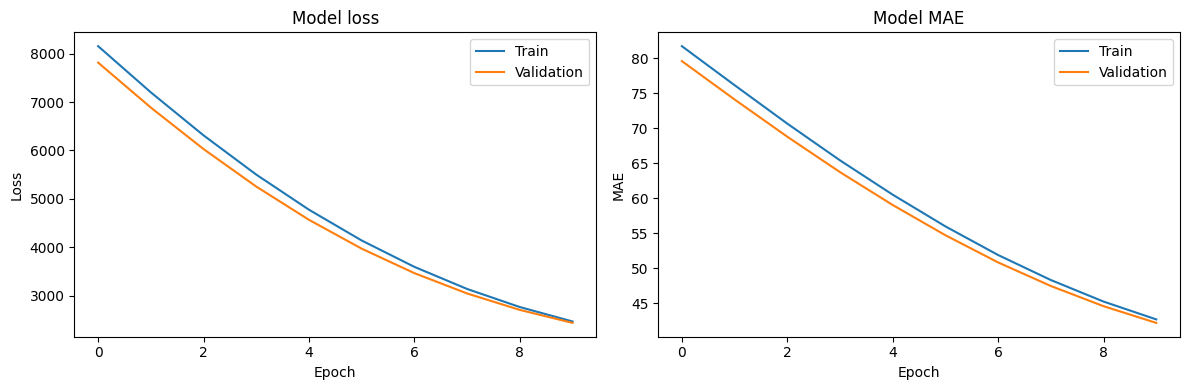

In [10]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# During training, capture the history object
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=(
        {
            "image_input": x_val_rgb,
            "sex_input": y_val_sex
        },
        y_val_age
    ),
    callbacks=callbacks,
    verbose=2
)

# After training, save the history to a file
history_dict = history.history

# Option 1: Save as JSON
history_file = f"{checkpoint_dir}/history_part_2_with_sex.json"
# Convert numpy values to Python native types for JSON serialization
for key in history_dict:
    history_dict[key] = [float(i) for i in history_dict[key]]

with open(history_file, 'w') as f:
    json.dump(history_dict, f)
print(f"Training history saved to {history_file}")

# Option 2: Save as CSV (easier to analyze in spreadsheet software)
history_df = pd.DataFrame(history_dict)
csv_file = f"{checkpoint_dir}/history_part_2_with_sex.csv"
history_df.to_csv(csv_file, index_label='epoch')
print(f"Training history saved to {csv_file}")

# Option 3: Create and save training plots
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation mae values
plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'])
plt.plot(history_dict['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plot_file = f"{checkpoint_dir}/training_plot_part_2_with_sex.png"
plt.savefig(plot_file)
print(f"Training plot saved to {plot_file}")

Tentative de chargement du modèle du segment 2...
Erreur lors du chargement du modèle: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Création d'un nouveau modèle...

🚀 Entraînement sur le segment 3/5 avec le sexe comme entrée
Epoch 1/10

Epoch 1: val_loss improved from inf to 17076.31055, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_3_with_sex.h5


63/63 - 38s - 606ms/step - loss: 17291.8594 - mae: 125.0430 - val_loss: 17076.3105 - val_mae: 123.8029 - learning_rate: 1.0000e-04
Epoch 2/10

Epoch 2: val_loss improved from 17076.31055 to 16162.33691, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_3_with_sex.h5


63/63 - 32s - 513ms/step - loss: 16365.5264 - mae: 121.2897 - val_loss: 16162.3369 - val_mae: 120.0642 - learning_rate: 1.0000e-04
Epoch 3/10

Epoch 3: val_loss improved from 16162.33691 to 15257.61719, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_3_with_sex.h5


63/63 - 32s - 507ms/step - loss: 15473.1963 - mae: 117.5608 - val_loss: 15257.6172 - val_mae: 116.2473 - learning_rate: 1.0000e-04
Epoch 4/10

Epoch 4: val_loss improved from 15257.61719 to 14298.01660, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_3_with_sex.h5


63/63 - 33s - 525ms/step - loss: 14550.5664 - mae: 113.5819 - val_loss: 14298.0166 - val_mae: 112.0686 - learning_rate: 1.0000e-04
Epoch 5/10

Epoch 5: val_loss improved from 14298.01660 to 13284.73926, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_3_with_sex.h5


63/63 - 32s - 509ms/step - loss: 13571.8076 - mae: 109.2094 - val_loss: 13284.7393 - val_mae: 107.4933 - learning_rate: 1.0000e-04
Epoch 6/10

Epoch 6: val_loss improved from 13284.73926 to 12234.22656, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_3_with_sex.h5


63/63 - 41s - 649ms/step - loss: 12547.6895 - mae: 104.4579 - val_loss: 12234.2266 - val_mae: 102.5777 - learning_rate: 1.0000e-04
Epoch 7/10

Epoch 7: val_loss improved from 12234.22656 to 11165.61133, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_3_with_sex.h5


63/63 - 32s - 513ms/step - loss: 11496.1387 - mae: 99.3777 - val_loss: 11165.6113 - val_mae: 97.3986 - learning_rate: 1.0000e-04
Epoch 8/10

Epoch 8: val_loss improved from 11165.61133 to 10098.78906, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_3_with_sex.h5


63/63 - 32s - 507ms/step - loss: 10436.6562 - mae: 94.0343 - val_loss: 10098.7891 - val_mae: 91.9890 - learning_rate: 1.0000e-04
Epoch 9/10

Epoch 9: val_loss improved from 10098.78906 to 9053.33984, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_3_with_sex.h5


63/63 - 32s - 508ms/step - loss: 9388.9277 - mae: 88.5360 - val_loss: 9053.3398 - val_mae: 86.4678 - learning_rate: 1.0000e-04
Epoch 10/10

Epoch 10: val_loss improved from 9053.33984 to 8047.60840, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_3_with_sex.h5


63/63 - 41s - 649ms/step - loss: 8371.8604 - mae: 82.9454 - val_loss: 8047.6084 - val_mae: 80.9133 - learning_rate: 1.0000e-04
Historique d'entraînement sauvegardé dans /content/drive/MyDrive/dataset-v2/checkpoints/history_part_3_with_sex.json
Historique d'entraînement sauvegardé dans /content/drive/MyDrive/dataset-v2/checkpoints/history_part_3_with_sex.csv
Graphique d'entraînement sauvegardé dans /content/drive/MyDrive/dataset-v2/checkpoints/training_plot_part_3_with_sex.png
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step

📊 [Segment 3 avec entrée de sexe] MAE: 80.9133 | MSE: 8047.6099
Métriques sauvegardées dans /content/drive/MyDrive/dataset-v2/checkpoints/metrics_part_3_with_sex.txt


10329

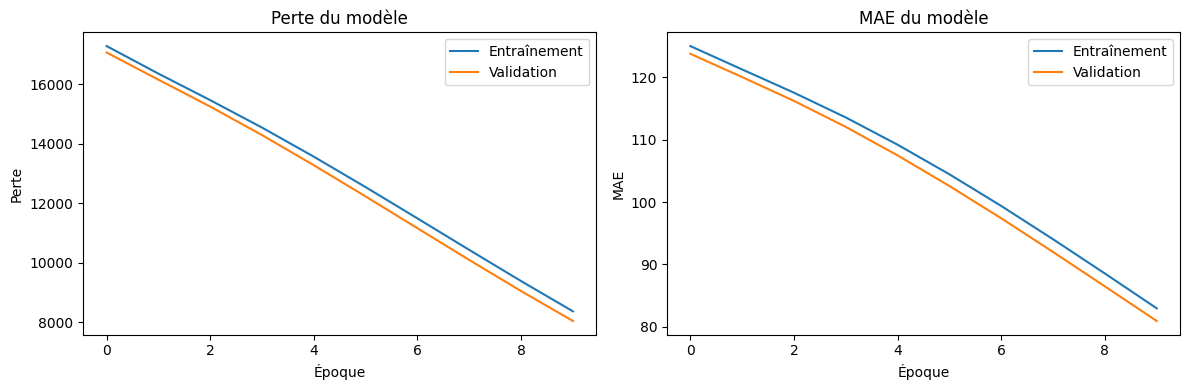

In [14]:
import numpy as np
import os
import gc
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Générateur de données avec sexe
class DataGeneratorWithSex:
    def __init__(self, x_path, y_age_path, y_sex_path, batch_size, part_idx, total_parts):
        self.x_path = x_path
        self.y_age_path = y_age_path
        self.y_sex_path = y_sex_path
        self.batch_size = batch_size
        self.part_idx = part_idx
        self.total_parts = total_parts
        self.x, self.y_age, self.y_sex = self.load_data_slice()

    def load_data_slice(self):
        x = np.load(self.x_path)
        y_age = np.load(self.y_age_path)
        y_sex = np.load(self.y_sex_path)

        total_len = len(x)
        part_size = total_len // self.total_parts
        start = self.part_idx * part_size
        end = (self.part_idx + 1) * part_size if self.part_idx < self.total_parts - 1 else total_len

        return x[start:end], y_age[start:end], y_sex[start:end]

    def create_tf_dataset(self):
        # Préparer les données
        x = self.x / 255.0
        x = np.repeat(x, 3, axis=-1).astype(np.float32)  # Convertir en RGB

        y_sex = self.y_sex.astype(np.float32)
        y_sex = np.expand_dims(y_sex, axis=-1)

        y_age = self.y_age.astype(np.float32)

        # Créer le dataset directement à partir des tableaux numpy
        dataset = tf.data.Dataset.from_tensor_slices(
            (
                {
                    "image_input": x,
                    "sex_input": y_sex
                },
                y_age
            )
        )

        # Batching du dataset
        dataset = dataset.batch(self.batch_size)

        # Prefetch pour de meilleures performances
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

# Fonction pour construire le modèle avec entrée de sexe
def build_model_with_sex_input():
    # Entrée d'image
    image_input = Input(shape=(224, 224, 3), name="image_input")
    base = VGG16(weights='imagenet', include_top=False, input_tensor=image_input)
    for layer in base.layers:
        layer.trainable = False  # Geler les couches de base pour le transfer learning

    x = base.output
    x = GlobalAveragePooling2D()(x)

    # Entrée de sexe
    sex_input = Input(shape=(1,), name="sex_input")

    # Combiner les deux entrées
    combined = Concatenate()([x, sex_input])
    combined = Dense(128, activation='relu')(combined)
    output = Dense(1)(combined)  # Prédire l'âge

    model = Model(inputs=[image_input, sex_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
    return model

# Paramètres d'entraînement
BATCH_SIZE = 32
EPOCHS = 10
PARTS = 5
SEGMENT = 3  # 3ème segment

# Répertoire des checkpoints
checkpoint_dir = '/content/drive/MyDrive/dataset-v2/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Deux options:
# 1. Charger le modèle précédent (segment 2)
try:
    print(f"Tentative de chargement du modèle du segment 2...")
    # Essayer d'abord le format .h5
    model_path = f"{checkpoint_dir}/model_part_2_with_sex.h5"
    if os.path.exists(model_path):
        model = load_model(model_path)
        print(f"Modèle chargé depuis {model_path}")
    else:
        # Essayer le format .keras
        model_path = f"{checkpoint_dir}/model_part_2_with_sex.keras"
        if os.path.exists(model_path):
            model = load_model(model_path)
            print(f"Modèle chargé depuis {model_path}")
        else:
            raise FileNotFoundError("Aucun modèle trouvé pour le segment 2")
except Exception as e:
    print(f"Erreur lors du chargement du modèle: {e}")
    print("Création d'un nouveau modèle...")
    # 2. Ou créer un nouveau modèle
    model = build_model_with_sex_input()

# Créer le générateur de données pour l'entraînement
train_generator = DataGeneratorWithSex(
    x_path='/content/drive/MyDrive/dataset-v2/npy_files/X_train.npy',
    y_age_path='/content/drive/MyDrive/dataset-v2/npy_files/y_train_age.npy',
    y_sex_path='/content/drive/MyDrive/dataset-v2/npy_files/sex_train.npy',
    batch_size=BATCH_SIZE,
    part_idx=SEGMENT-1,  # Convertir en index 0-based (segment 3 = index 2)
    total_parts=PARTS
)

# Créer le dataset TF
train_dataset = train_generator.create_tf_dataset()

# Préparer les données de validation
x_val = np.load('/content/drive/MyDrive/dataset-v2/npy_files/X_val.npy') / 255.0
y_val_age = np.load('/content/drive/MyDrive/dataset-v2/npy_files/y_val_age.npy')
y_val_sex = np.load('/content/drive/MyDrive/dataset-v2/npy_files/sex_val.npy')
x_val_rgb = np.repeat(x_val, 3, axis=-1).astype(np.float32)
y_val_sex = np.expand_dims(y_val_sex, axis=-1).astype(np.float32)

# Callbacks d'entraînement
model_path = f"{checkpoint_dir}/model_part_{SEGMENT}_with_sex.h5"
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5, verbose=1),
    ModelCheckpoint(filepath=model_path, save_best_only=True, monitor='val_loss', verbose=1)
]

print(f"\n🚀 Entraînement sur le segment {SEGMENT}/{PARTS} avec le sexe comme entrée")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=(
        {
            "image_input": x_val_rgb,
            "sex_input": y_val_sex
        },
        y_val_age
    ),
    callbacks=callbacks,
    verbose=2
)

# Sauvegarder l'historique d'entraînement
history_dict = history.history

# Convertir les valeurs numpy en types Python natifs pour la sérialisation JSON
for key in history_dict:
    history_dict[key] = [float(i) for i in history_dict[key]]

# Sauvegarder en JSON
history_file = f"{checkpoint_dir}/history_part_{SEGMENT}_with_sex.json"
with open(history_file, 'w') as f:
    json.dump(history_dict, f)
print(f"Historique d'entraînement sauvegardé dans {history_file}")

# Sauvegarder en CSV
history_df = pd.DataFrame(history_dict)
csv_file = f"{checkpoint_dir}/history_part_{SEGMENT}_with_sex.csv"
history_df.to_csv(csv_file, index_label='epoch')
print(f"Historique d'entraînement sauvegardé dans {csv_file}")

# Créer et sauvegarder les graphiques d'entraînement
plt.figure(figsize=(12, 4))

# Graphique des valeurs de perte d'entraînement et de validation
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Perte du modèle')
plt.ylabel('Perte')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper right')

# Graphique des valeurs MAE d'entraînement et de validation
plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'])
plt.plot(history_dict['val_mae'])
plt.title('MAE du modèle')
plt.ylabel('MAE')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper right')

plt.tight_layout()
plot_file = f"{checkpoint_dir}/training_plot_part_{SEGMENT}_with_sex.png"
plt.savefig(plot_file)
print(f"Graphique d'entraînement sauvegardé dans {plot_file}")

# Évaluer sur les données de validation
predictions = model.predict({
    "image_input": x_val_rgb,
    "sex_input": y_val_sex
})
mae = mean_absolute_error(y_val_age, predictions)
mse = mean_squared_error(y_val_age, predictions)
print(f"\n📊 [Segment {SEGMENT} avec entrée de sexe] MAE: {mae:.4f} | MSE: {mse:.4f}")

# Sauvegarder les métriques dans un fichier
metrics_file = f"{checkpoint_dir}/metrics_part_{SEGMENT}_with_sex.txt"
with open(metrics_file, 'w') as f:
    f.write(f"MAE: {mae:.4f}\n")
    f.write(f"MSE: {mse:.4f}\n")
print(f"Métriques sauvegardées dans {metrics_file}")

# Libérer la mémoire après l'entraînement
gc.collect()

Tentative de chargement du modèle du segment 3...
Erreur lors du chargement du modèle: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Création d'un nouveau modèle amélioré...

🚀 Entraînement sur le segment 4/5 avec le sexe comme entrée
🔄 Utilisation du modèle avec fine-tuning des dernières couches VGG16
Epoch 1/15

Epoch 1: val_loss improved from inf to 18100.86719, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_4_with_sex.h5


63/63 - 44s - 701ms/step - loss: 17678.5352 - mae: 126.6348 - val_loss: 18100.8672 - val_mae: 127.8822 - learning_rate: 5.0000e-05
Epoch 2/15

Epoch 2: val_loss improved from 18100.86719 to 17977.51758, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_4_with_sex.h5


63/63 - 34s - 543ms/step - loss: 17557.4180 - mae: 126.5675 - val_loss: 17977.5176 - val_mae: 127.4819 - learning_rate: 5.0000e-05
Epoch 3/15

Epoch 3: val_loss did not improve from 17977.51758
63/63 - 39s - 624ms/step - loss: 17440.8848 - mae: 126.5499 - val_loss: 17981.2090 - val_mae: 127.6469 - learning_rate: 5.0000e-05
Epoch 4/15

Epoch 4: val_loss did not improve from 17977.51758
63/63 - 41s - 649ms/step - loss: 17328.8965 - mae: 126.4746 - val_loss: 18012.8223 - val_mae: 128.0840 - learning_rate: 5.0000e-05
Epoch 5/15

Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 5: val_loss did not improve from 17977.51758
63/63 - 25s - 396ms/step - loss: 17239.5410 - mae: 126.4514 - val_loss: 18060.8340 - val_mae: 128.6401 - learning_rate: 5.0000e-05
Epoch 6/15

Epoch 6: val_loss improved from 17977.51758 to 17614.46875, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_4_with_sex.h5


63/63 - 36s - 566ms/step - loss: 17165.9219 - mae: 126.3782 - val_loss: 17614.4688 - val_mae: 126.9729 - learning_rate: 1.0000e-05
Epoch 7/15

Epoch 7: val_loss did not improve from 17614.46875
63/63 - 38s - 606ms/step - loss: 17145.4766 - mae: 126.3708 - val_loss: 17690.0430 - val_mae: 127.4175 - learning_rate: 1.0000e-05
Epoch 8/15

Epoch 8: val_loss did not improve from 17614.46875
63/63 - 41s - 648ms/step - loss: 17131.0078 - mae: 126.3815 - val_loss: 17696.7871 - val_mae: 127.5942 - learning_rate: 1.0000e-05
Epoch 9/15

Epoch 9: val_loss improved from 17614.46875 to 17589.76953, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_4_with_sex.h5


63/63 - 36s - 569ms/step - loss: 17112.6758 - mae: 126.3647 - val_loss: 17589.7695 - val_mae: 127.3148 - learning_rate: 1.0000e-05
Epoch 10/15

Epoch 10: val_loss did not improve from 17589.76953
63/63 - 33s - 524ms/step - loss: 17085.9961 - mae: 126.3219 - val_loss: 17669.2402 - val_mae: 127.8018 - learning_rate: 1.0000e-05
Epoch 11/15

Epoch 11: val_loss did not improve from 17589.76953
63/63 - 33s - 522ms/step - loss: 17074.7441 - mae: 126.3235 - val_loss: 17756.9590 - val_mae: 128.1985 - learning_rate: 1.0000e-05
Epoch 12/15

Epoch 12: val_loss improved from 17589.76953 to 17576.11523, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_4_with_sex.h5


63/63 - 35s - 558ms/step - loss: 17062.5703 - mae: 126.3278 - val_loss: 17576.1152 - val_mae: 127.5402 - learning_rate: 1.0000e-05
Epoch 13/15

Epoch 13: val_loss did not improve from 17576.11523
63/63 - 39s - 614ms/step - loss: 17046.8457 - mae: 126.3245 - val_loss: 17633.0312 - val_mae: 127.7711 - learning_rate: 1.0000e-05
Epoch 14/15

Epoch 14: val_loss improved from 17576.11523 to 17530.62500, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_4_with_sex.h5


63/63 - 44s - 698ms/step - loss: 17033.9355 - mae: 126.3253 - val_loss: 17530.6250 - val_mae: 127.4160 - learning_rate: 1.0000e-05
Epoch 15/15

Epoch 15: val_loss improved from 17530.62500 to 17237.75977, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_4_with_sex.h5


63/63 - 38s - 602ms/step - loss: 17015.8281 - mae: 126.3047 - val_loss: 17237.7598 - val_mae: 126.3665 - learning_rate: 1.0000e-05
Historique d'entraînement sauvegardé dans /content/drive/MyDrive/dataset-v2/checkpoints/history_part_4_with_sex.json
Historique d'entraînement sauvegardé dans /content/drive/MyDrive/dataset-v2/checkpoints/history_part_4_with_sex.csv
Graphique d'entraînement sauvegardé dans /content/drive/MyDrive/dataset-v2/checkpoints/training_plot_part_4_with_sex.png
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 171ms/step

📊 [Segment 4 avec entrée de sexe] MAE: 126.3665 | MSE: 17237.2500
Métriques sauvegardées dans /content/drive/MyDrive/dataset-v2/checkpoints/metrics_part_4_with_sex.txt


11334

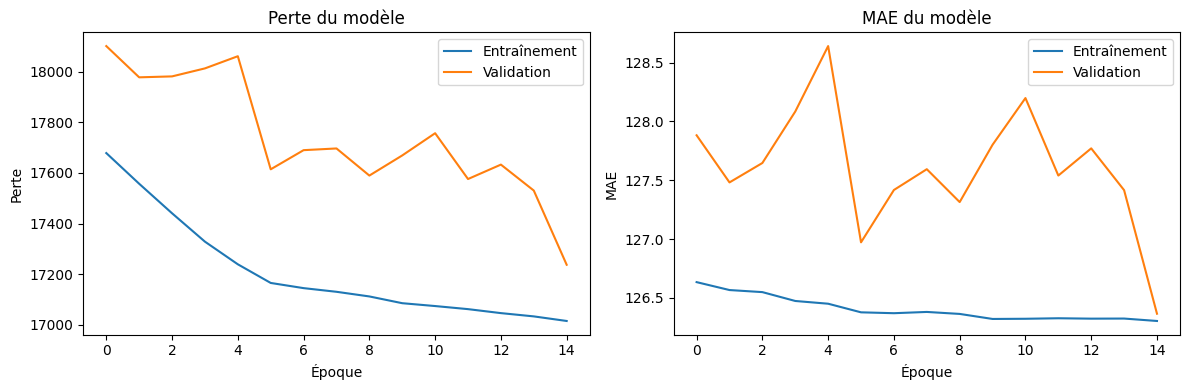

In [18]:
import numpy as np
import os
import gc
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Générateur de données avec sexe (inchangé)
class DataGeneratorWithSex:
    def __init__(self, x_path, y_age_path, y_sex_path, batch_size, part_idx, total_parts):
        self.x_path = x_path
        self.y_age_path = y_age_path
        self.y_sex_path = y_sex_path
        self.batch_size = batch_size
        self.part_idx = part_idx
        self.total_parts = total_parts
        self.x, self.y_age, self.y_sex = self.load_data_slice()

    def load_data_slice(self):
        x = np.load(self.x_path)
        y_age = np.load(self.y_age_path)
        y_sex = np.load(self.y_sex_path)

        total_len = len(x)
        part_size = total_len // self.total_parts
        start = self.part_idx * part_size
        end = (self.part_idx + 1) * part_size if self.part_idx < self.total_parts - 1 else total_len

        return x[start:end], y_age[start:end], y_sex[start:end]

    def create_tf_dataset(self):
        # Préparer les données
        x = self.x / 255.0
        x = np.repeat(x, 3, axis=-1).astype(np.float32)  # Convertir en RGB

        y_sex = self.y_sex.astype(np.float32)
        y_sex = np.expand_dims(y_sex, axis=-1)

        y_age = self.y_age.astype(np.float32)

        # Créer le dataset directement à partir des tableaux numpy
        dataset = tf.data.Dataset.from_tensor_slices(
            (
                {
                    "image_input": x,
                    "sex_input": y_sex
                },
                y_age
            )
        )

        # Batching du dataset
        dataset = dataset.batch(self.batch_size)

        # Prefetch pour de meilleures performances
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

# Fonction améliorée pour construire le modèle avec entrée de sexe
def build_improved_model_with_sex_input():
    # Entrée d'image
    image_input = Input(shape=(224, 224, 3), name="image_input")

    # Charger VGG16 sans les couches supérieures
    base = VGG16(weights='imagenet', include_top=False, input_tensor=image_input)

    # Geler les premières couches mais dégeler les dernières pour un fine-tuning
    # Geler les 15 premières couches (sur 19 au total dans VGG16)
    for layer in base.layers[:15]:
        layer.trainable = False

    # Dégeler les 4 dernières couches pour permettre un ajustement fin
    for layer in base.layers[15:]:
        layer.trainable = True

    # Extraction de caractéristiques
    x = base.output
    x = GlobalAveragePooling2D()(x)

    # Amélioration: Ajouter BatchNormalization pour stabiliser l'entraînement
    x = BatchNormalization()(x)

    # Entrée de sexe
    sex_input = Input(shape=(1,), name="sex_input")

    # Combiner les deux entrées
    combined = Concatenate()([x, sex_input])

    # Amélioration: Architecture plus profonde avec régularisation
    combined = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(combined)
    combined = BatchNormalization()(combined)
    combined = Dropout(0.3)(combined)

    combined = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(combined)
    combined = BatchNormalization()(combined)
    combined = Dropout(0.2)(combined)

    # Couche de sortie pour prédire l'âge
    output = Dense(1)(combined)

    model = Model(inputs=[image_input, sex_input], outputs=output)

    # Utiliser un taux d'apprentissage plus faible pour le fine-tuning
    model.compile(optimizer=Adam(learning_rate=5e-5), loss='mse', metrics=['mae'])

    return model

# Paramètres d'entraînement
BATCH_SIZE = 32
EPOCHS = 15  # Augmenter le nombre d'époques pour permettre un meilleur apprentissage
PARTS = 5
SEGMENT = 4  # 4ème segment

# Répertoire des checkpoints
checkpoint_dir = '/content/drive/MyDrive/dataset-v2/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Charger le modèle précédent (segment 3) ou créer un nouveau modèle amélioré
try:
    print(f"Tentative de chargement du modèle du segment 3...")
    model_path = f"{checkpoint_dir}/model_part_3_with_sex.h5"
    if os.path.exists(model_path):
        # Charger le modèle de base
        base_model = load_model(model_path)
        print(f"Modèle chargé depuis {model_path}")

        # Extraire les poids pour les transférer au modèle amélioré
        weights = base_model.get_weights()

        # Créer le modèle amélioré
        model = build_improved_model_with_sex_input()

        # Tenter de transférer les poids compatibles
        try:
            model.set_weights(weights)
            print("Poids transférés avec succès au modèle amélioré")
        except ValueError:
            print("Impossible de transférer les poids directement - architecture différente")
            print("Utilisation du modèle amélioré avec initialisation des poids par défaut")
    else:
        raise FileNotFoundError("Aucun modèle trouvé pour le segment 3")
except Exception as e:
    print(f"Erreur lors du chargement du modèle: {e}")
    print("Création d'un nouveau modèle amélioré...")
    model = build_improved_model_with_sex_input()

# Créer le générateur de données pour l'entraînement
train_generator = DataGeneratorWithSex(
    x_path='/content/drive/MyDrive/dataset-v2/npy_files/X_train.npy',
    y_age_path='/content/drive/MyDrive/dataset-v2/npy_files/y_train_age.npy',
    y_sex_path='/content/drive/MyDrive/dataset-v2/npy_files/sex_train.npy',
    batch_size=BATCH_SIZE,
    part_idx=SEGMENT-1,  # Convertir en index 0-based (segment 4 = index 3)
    total_parts=PARTS
)

# Créer le dataset TF
train_dataset = train_generator.create_tf_dataset()

# Préparer les données de validation
x_val = np.load('/content/drive/MyDrive/dataset-v2/npy_files/X_val.npy') / 255.0
y_val_age = np.load('/content/drive/MyDrive/dataset-v2/npy_files/y_val_age.npy')
y_val_sex = np.load('/content/drive/MyDrive/dataset-v2/npy_files/sex_val.npy')
x_val_rgb = np.repeat(x_val, 3, axis=-1).astype(np.float32)
y_val_sex = np.expand_dims(y_val_sex, axis=-1).astype(np.float32)

# Callbacks d'entraînement améliorés
model_path = f"{checkpoint_dir}/model_part_{SEGMENT}_with_sex.h5"
callbacks = [
    # Patience augmentée pour permettre plus de temps d'apprentissage
    EarlyStopping(patience=5, restore_best_weights=True),

    # Réduction du taux d'apprentissage plus progressive
    ReduceLROnPlateau(patience=3, factor=0.2, min_lr=1e-6, verbose=1),

    # Sauvegarde du modèle
    ModelCheckpoint(filepath=model_path, save_best_only=True, monitor='val_loss', verbose=1)
]

print(f"\n🚀 Entraînement sur le segment {SEGMENT}/{PARTS} avec le sexe comme entrée")
print(f"🔄 Utilisation du modèle avec fine-tuning des dernières couches VGG16")

# Libérer de la mémoire avant l'entraînement
gc.collect()
tf.keras.backend.clear_session()

# Entraînement avec historique
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=(
        {
            "image_input": x_val_rgb,
            "sex_input": y_val_sex
        },
        y_val_age
    ),
    callbacks=callbacks,
    verbose=2
)

# Sauvegarder l'historique d'entraînement
history_dict = history.history

# Convertir les valeurs numpy en types Python natifs pour la sérialisation JSON
for key in history_dict:
    history_dict[key] = [float(i) for i in history_dict[key]]

# Sauvegarder en JSON
history_file = f"{checkpoint_dir}/history_part_{SEGMENT}_with_sex.json"
with open(history_file, 'w') as f:
    json.dump(history_dict, f)
print(f"Historique d'entraînement sauvegardé dans {history_file}")

# Sauvegarder en CSV
history_df = pd.DataFrame(history_dict)
csv_file = f"{checkpoint_dir}/history_part_{SEGMENT}_with_sex.csv"
history_df.to_csv(csv_file, index_label='epoch')
print(f"Historique d'entraînement sauvegardé dans {csv_file}")

# Créer et sauvegarder les graphiques d'entraînement
plt.figure(figsize=(12, 4))

# Graphique des valeurs de perte d'entraînement et de validation
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Perte du modèle')
plt.ylabel('Perte')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper right')

# Graphique des valeurs MAE d'entraînement et de validation
plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'])
plt.plot(history_dict['val_mae'])
plt.title('MAE du modèle')
plt.ylabel('MAE')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper right')

plt.tight_layout()
plot_file = f"{checkpoint_dir}/training_plot_part_{SEGMENT}_with_sex.png"
plt.savefig(plot_file)
print(f"Graphique d'entraînement sauvegardé dans {plot_file}")

# Évaluer sur les données de validation
predictions = model.predict({
    "image_input": x_val_rgb,
    "sex_input": y_val_sex
})
mae = mean_absolute_error(y_val_age, predictions)
mse = mean_squared_error(y_val_age, predictions)
print(f"\n📊 [Segment {SEGMENT} avec entrée de sexe] MAE: {mae:.4f} | MSE: {mse:.4f}")

# Sauvegarder les métriques dans un fichier
metrics_file = f"{checkpoint_dir}/metrics_part_{SEGMENT}_with_sex.txt"
with open(metrics_file, 'w') as f:
    f.write(f"MAE: {mae:.4f}\n")
    f.write(f"MSE: {mse:.4f}\n")
print(f"Métriques sauvegardées dans {metrics_file}")

# Libérer la mémoire après l'entraînement
gc.collect()

In [23]:
import gc
gc.collect()

0


🚀 Entraînement sur le segment 4/5 avec entrée de sexe
Epoch 1/10

Epoch 1: val_loss improved from inf to 16940.20703, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_4_with_sex.h5


63/63 - 32s - 511ms/step - loss: 16980.5703 - mae: 123.7274 - val_loss: 16940.2070 - val_mae: 123.2536 - learning_rate: 1.0000e-04
Epoch 2/10

Epoch 2: val_loss improved from 16940.20703 to 15989.74316, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_4_with_sex.h5


63/63 - 44s - 692ms/step - loss: 16048.5703 - mae: 119.9138 - val_loss: 15989.7432 - val_mae: 119.3454 - learning_rate: 1.0000e-04
Epoch 3/10

Epoch 3: val_loss improved from 15989.74316 to 14983.94629, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_4_with_sex.h5


63/63 - 33s - 526ms/step - loss: 15085.0615 - mae: 115.8436 - val_loss: 14983.9463 - val_mae: 115.0701 - learning_rate: 1.0000e-04
Epoch 4/10

Epoch 4: val_loss improved from 14983.94629 to 13892.31348, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_4_with_sex.h5


63/63 - 32s - 503ms/step - loss: 14051.2930 - mae: 111.3261 - val_loss: 13892.3135 - val_mae: 110.2594 - learning_rate: 1.0000e-04
Epoch 5/10

Epoch 5: val_loss improved from 13892.31348 to 12727.98926, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_4_with_sex.h5


63/63 - 31s - 499ms/step - loss: 12937.6143 - mae: 106.2795 - val_loss: 12727.9893 - val_mae: 104.9074 - learning_rate: 1.0000e-04
Epoch 6/10

Epoch 6: val_loss improved from 12727.98926 to 11518.64551, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_4_with_sex.h5


63/63 - 41s - 654ms/step - loss: 11765.8086 - mae: 100.7262 - val_loss: 11518.6455 - val_mae: 99.1366 - learning_rate: 1.0000e-04
Epoch 7/10

Epoch 7: val_loss improved from 11518.64551 to 10297.09961, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_4_with_sex.h5


63/63 - 32s - 506ms/step - loss: 10566.4502 - mae: 94.7735 - val_loss: 10297.0996 - val_mae: 93.0117 - learning_rate: 1.0000e-04
Epoch 8/10

Epoch 8: val_loss improved from 10297.09961 to 9095.76953, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_4_with_sex.h5


63/63 - 41s - 645ms/step - loss: 9372.2129 - mae: 88.5280 - val_loss: 9095.7695 - val_mae: 86.6969 - learning_rate: 1.0000e-04
Epoch 9/10

Epoch 9: val_loss improved from 9095.76953 to 7944.34277, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_4_with_sex.h5


63/63 - 25s - 394ms/step - loss: 8214.0000 - mae: 82.1272 - val_loss: 7944.3428 - val_mae: 80.3268 - learning_rate: 1.0000e-04
Epoch 10/10

Epoch 10: val_loss improved from 7944.34277 to 6868.52344, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_4_with_sex.h5


63/63 - 32s - 505ms/step - loss: 7119.3345 - mae: 75.6679 - val_loss: 6868.5234 - val_mae: 74.0021 - learning_rate: 1.0000e-04
Historique d'entraînement sauvegardé dans /content/drive/MyDrive/dataset-v2/checkpoints/history_part_4_with_sex.json
Historique d'entraînement sauvegardé dans /content/drive/MyDrive/dataset-v2/checkpoints/history_part_4_with_sex.csv
Graphique d'entraînement sauvegardé dans /content/drive/MyDrive/dataset-v2/checkpoints/training_plot_part_4_with_sex.png
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 165ms/step

📊 [Segment 4 avec entrée de sexe] MAE: 74.0021 | MSE: 6868.5244
Métriques sauvegardées dans /content/drive/MyDrive/dataset-v2/checkpoints/metrics_part_4_with_sex.txt


13363

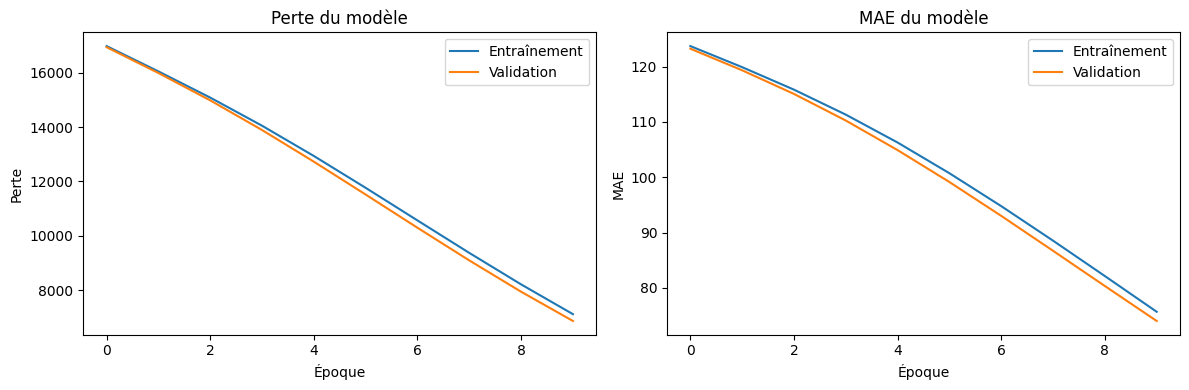

In [21]:
import numpy as np
import os
import gc
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Générateur de données avec sexe
class DataGeneratorWithSex:
    def __init__(self, x_path, y_age_path, y_sex_path, batch_size, part_idx, total_parts):
        self.x_path = x_path
        self.y_age_path = y_age_path
        self.y_sex_path = y_sex_path
        self.batch_size = batch_size
        self.part_idx = part_idx
        self.total_parts = total_parts
        self.x, self.y_age, self.y_sex = self.load_data_slice()

    def load_data_slice(self):
        x = np.load(self.x_path)
        y_age = np.load(self.y_age_path)
        y_sex = np.load(self.y_sex_path)

        total_len = len(x)
        part_size = total_len // self.total_parts
        start = self.part_idx * part_size
        end = (self.part_idx + 1) * part_size if self.part_idx < self.total_parts - 1 else total_len

        return x[start:end], y_age[start:end], y_sex[start:end]

    def create_tf_dataset(self):
        # Préparer les données
        x = self.x / 255.0
        x = np.repeat(x, 3, axis=-1).astype(np.float32)  # Convertir en RGB

        y_sex = self.y_sex.astype(np.float32)
        y_sex = np.expand_dims(y_sex, axis=-1)

        y_age = self.y_age.astype(np.float32)

        # Créer le dataset directement à partir des tableaux numpy
        dataset = tf.data.Dataset.from_tensor_slices(
            (
                {
                    "image_input": x,
                    "sex_input": y_sex
                },
                y_age
            )
        )

        # Batching du dataset
        dataset = dataset.batch(self.batch_size)

        # Prefetch pour de meilleures performances
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

# Modèle avec entrée de sexe (inchangé)
def build_model_with_sex_input():
    # Entrée d'image
    image_input = Input(shape=(224, 224, 3), name="image_input")
    base = VGG16(weights='imagenet', include_top=False, input_tensor=image_input)
    for layer in base.layers:
        layer.trainable = False  # Geler les couches de base pour le transfer learning

    x = base.output
    x = GlobalAveragePooling2D()(x)

    # Entrée de sexe
    sex_input = Input(shape=(1,), name="sex_input")

    # Combiner les deux entrées
    combined = Concatenate()([x, sex_input])
    combined = Dense(128, activation='relu')(combined)
    output = Dense(1)(combined)  # Prédire l'âge

    model = Model(inputs=[image_input, sex_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
    return model

# Paramètres d'entraînement
BATCH_SIZE = 32
EPOCHS = 10
PARTS = 5
SEGMENT = 4  # 4ème segment

# Répertoire des checkpoints
checkpoint_dir = '/content/drive/MyDrive/dataset-v2/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Créer le modèle
model = build_model_with_sex_input()

# Créer le générateur de données pour l'entraînement
train_generator = DataGeneratorWithSex(
    x_path='/content/drive/MyDrive/dataset-v2/npy_files/X_train.npy',
    y_age_path='/content/drive/MyDrive/dataset-v2/npy_files/y_train_age.npy',
    y_sex_path='/content/drive/MyDrive/dataset-v2/npy_files/sex_train.npy',
    batch_size=BATCH_SIZE,
    part_idx=SEGMENT-1,  # Convertir en index 0-based (segment 4 = index 3)
    total_parts=PARTS
)

# Créer le dataset TF
train_dataset = train_generator.create_tf_dataset()

# Préparer les données de validation
x_val = np.load('/content/drive/MyDrive/dataset-v2/npy_files/X_val.npy') / 255.0
y_val_age = np.load('/content/drive/MyDrive/dataset-v2/npy_files/y_val_age.npy')
y_val_sex = np.load('/content/drive/MyDrive/dataset-v2/npy_files/sex_val.npy')
x_val_rgb = np.repeat(x_val, 3, axis=-1).astype(np.float32)
y_val_sex = np.expand_dims(y_val_sex, axis=-1).astype(np.float32)

# Callbacks d'entraînement
model_path = f"{checkpoint_dir}/model_part_{SEGMENT}_with_sex.h5"
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5, verbose=1),
    ModelCheckpoint(filepath=model_path, save_best_only=True, monitor='val_loss', verbose=1)
]

print(f"\n🚀 Entraînement sur le segment {SEGMENT}/{PARTS} avec entrée de sexe")

# Libérer de la mémoire avant l'entraînement
gc.collect()
tf.keras.backend.clear_session()

# Entraînement avec historique
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=(
        {
            "image_input": x_val_rgb,
            "sex_input": y_val_sex
        },
        y_val_age
    ),
    callbacks=callbacks,
    verbose=2
)

# Sauvegarder l'historique d'entraînement (optionnel)
history_dict = history.history

# Convertir les valeurs numpy en types Python natifs pour la sérialisation JSON
for key in history_dict:
    history_dict[key] = [float(i) for i in history_dict[key]]

# Sauvegarder en JSON
history_file = f"{checkpoint_dir}/history_part_{SEGMENT}_with_sex.json"
with open(history_file, 'w') as f:
    json.dump(history_dict, f)
print(f"Historique d'entraînement sauvegardé dans {history_file}")

# Sauvegarder en CSV
history_df = pd.DataFrame(history_dict)
csv_file = f"{checkpoint_dir}/history_part_{SEGMENT}_with_sex.csv"
history_df.to_csv(csv_file, index_label='epoch')
print(f"Historique d'entraînement sauvegardé dans {csv_file}")

# Créer et sauvegarder les graphiques d'entraînement
plt.figure(figsize=(12, 4))

# Graphique des valeurs de perte d'entraînement et de validation
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Perte du modèle')
plt.ylabel('Perte')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper right')

# Graphique des valeurs MAE d'entraînement et de validation
plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'])
plt.plot(history_dict['val_mae'])
plt.title('MAE du modèle')
plt.ylabel('MAE')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper right')

plt.tight_layout()
plot_file = f"{checkpoint_dir}/training_plot_part_{SEGMENT}_with_sex.png"
plt.savefig(plot_file)
print(f"Graphique d'entraînement sauvegardé dans {plot_file}")

# Évaluer sur les données de validation
predictions = model.predict({
    "image_input": x_val_rgb,
    "sex_input": y_val_sex
})
mae = mean_absolute_error(y_val_age, predictions)
mse = mean_squared_error(y_val_age, predictions)
print(f"\n📊 [Segment {SEGMENT} avec entrée de sexe] MAE: {mae:.4f} | MSE: {mse:.4f}")

# Sauvegarder les métriques dans un fichier
metrics_file = f"{checkpoint_dir}/metrics_part_{SEGMENT}_with_sex.txt"
with open(metrics_file, 'w') as f:
    f.write(f"MAE: {mae:.4f}\n")
    f.write(f"MSE: {mse:.4f}\n")
print(f"Métriques sauvegardées dans {metrics_file}")

# Libérer la mémoire après l'entraînement
gc.collect()


🚀 Entraînement sur le segment 5/5 avec entrée de sexe
Epoch 1/10

Epoch 1: val_loss improved from inf to 17009.93945, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_5_with_sex.h5


63/63 - 38s - 603ms/step - loss: 16936.0723 - mae: 123.4335 - val_loss: 17009.9395 - val_mae: 123.5364 - learning_rate: 1.0000e-04
Epoch 2/10

Epoch 2: val_loss improved from 17009.93945 to 16111.96484, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_5_with_sex.h5


63/63 - 31s - 499ms/step - loss: 16012.2793 - mae: 119.6423 - val_loss: 16111.9648 - val_mae: 119.8557 - learning_rate: 1.0000e-04
Epoch 3/10

Epoch 3: val_loss improved from 16111.96484 to 15191.29199, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_5_with_sex.h5


63/63 - 31s - 497ms/step - loss: 15126.0713 - mae: 115.8927 - val_loss: 15191.2920 - val_mae: 115.9643 - learning_rate: 1.0000e-04
Epoch 4/10

Epoch 4: val_loss improved from 15191.29199 to 14209.31641, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_5_with_sex.h5


63/63 - 33s - 524ms/step - loss: 14191.9521 - mae: 111.8091 - val_loss: 14209.3164 - val_mae: 111.6775 - learning_rate: 1.0000e-04
Epoch 5/10

Epoch 5: val_loss improved from 14209.31641 to 13173.97461, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_5_with_sex.h5


63/63 - 32s - 501ms/step - loss: 13200.3740 - mae: 107.3299 - val_loss: 13173.9746 - val_mae: 106.9847 - learning_rate: 1.0000e-04
Epoch 6/10

Epoch 6: val_loss improved from 13173.97461 to 12103.23340, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_5_with_sex.h5


63/63 - 24s - 380ms/step - loss: 12165.6670 - mae: 102.4810 - val_loss: 12103.2334 - val_mae: 101.9574 - learning_rate: 1.0000e-04
Epoch 7/10

Epoch 7: val_loss improved from 12103.23340 to 11017.40918, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_5_with_sex.h5


63/63 - 32s - 507ms/step - loss: 11107.0723 - mae: 97.3226 - val_loss: 11017.4092 - val_mae: 96.6647 - learning_rate: 1.0000e-04
Epoch 8/10

Epoch 8: val_loss improved from 11017.40918 to 9937.37891, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_5_with_sex.h5


63/63 - 41s - 649ms/step - loss: 10045.1279 - mae: 91.9132 - val_loss: 9937.3789 - val_mae: 91.1574 - learning_rate: 1.0000e-04
Epoch 9/10

Epoch 9: val_loss improved from 9937.37891 to 8883.42188, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_5_with_sex.h5


63/63 - 32s - 506ms/step - loss: 9000.3145 - mae: 86.3269 - val_loss: 8883.4219 - val_mae: 85.5526 - learning_rate: 1.0000e-04
Epoch 10/10

Epoch 10: val_loss improved from 8883.42188 to 7874.32373, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/model_part_5_with_sex.h5


63/63 - 32s - 507ms/step - loss: 7992.0166 - mae: 80.6344 - val_loss: 7874.3237 - val_mae: 79.9302 - learning_rate: 1.0000e-04
Historique d'entraînement sauvegardé dans /content/drive/MyDrive/dataset-v2/checkpoints/history_part_5_with_sex.json
Historique d'entraînement sauvegardé dans /content/drive/MyDrive/dataset-v2/checkpoints/history_part_5_with_sex.csv
Graphique d'entraînement sauvegardé dans /content/drive/MyDrive/dataset-v2/checkpoints/training_plot_part_5_with_sex.png
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 169ms/step

📊 [Segment 5 avec entrée de sexe] MAE: 79.9302 | MSE: 7874.3257
Métriques sauvegardées dans /content/drive/MyDrive/dataset-v2/checkpoints/metrics_part_5_with_sex.txt


10301

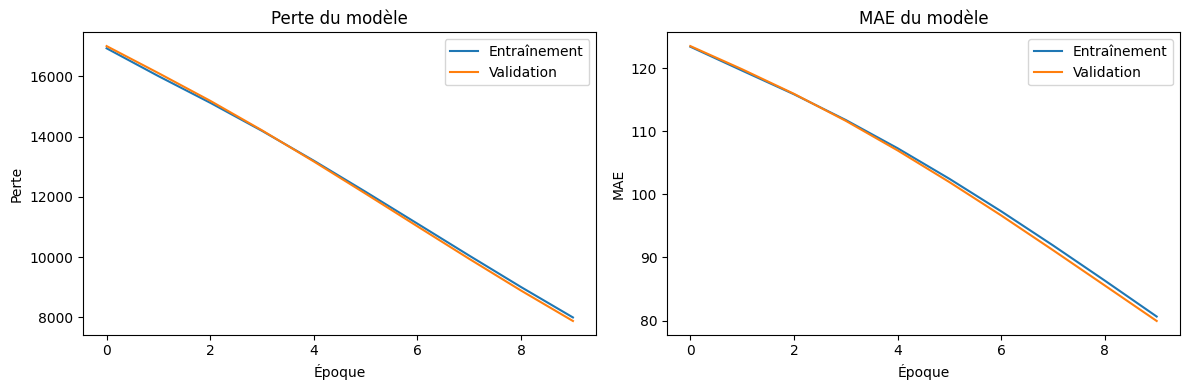

In [24]:
import numpy as np
import os
import gc
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Générateur de données avec sexe
class DataGeneratorWithSex:
    def __init__(self, x_path, y_age_path, y_sex_path, batch_size, part_idx, total_parts):
        self.x_path = x_path
        self.y_age_path = y_age_path
        self.y_sex_path = y_sex_path
        self.batch_size = batch_size
        self.part_idx = part_idx
        self.total_parts = total_parts
        self.x, self.y_age, self.y_sex = self.load_data_slice()

    def load_data_slice(self):
        x = np.load(self.x_path)
        y_age = np.load(self.y_age_path)
        y_sex = np.load(self.y_sex_path)

        total_len = len(x)
        part_size = total_len // self.total_parts
        start = self.part_idx * part_size
        end = (self.part_idx + 1) * part_size if self.part_idx < self.total_parts - 1 else total_len

        return x[start:end], y_age[start:end], y_sex[start:end]

    def create_tf_dataset(self):
        # Préparer les données
        x = self.x / 255.0
        x = np.repeat(x, 3, axis=-1).astype(np.float32)  # Convertir en RGB

        y_sex = self.y_sex.astype(np.float32)
        y_sex = np.expand_dims(y_sex, axis=-1)

        y_age = self.y_age.astype(np.float32)

        # Créer le dataset directement à partir des tableaux numpy
        dataset = tf.data.Dataset.from_tensor_slices(
            (
                {
                    "image_input": x,
                    "sex_input": y_sex
                },
                y_age
            )
        )

        # Batching du dataset
        dataset = dataset.batch(self.batch_size)

        # Prefetch pour de meilleures performances
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

# Modèle avec entrée de sexe (inchangé)
def build_model_with_sex_input():
    # Entrée d'image
    image_input = Input(shape=(224, 224, 3), name="image_input")
    base = VGG16(weights='imagenet', include_top=False, input_tensor=image_input)
    for layer in base.layers:
        layer.trainable = False  # Geler les couches de base pour le transfer learning

    x = base.output
    x = GlobalAveragePooling2D()(x)

    # Entrée de sexe
    sex_input = Input(shape=(1,), name="sex_input")

    # Combiner les deux entrées
    combined = Concatenate()([x, sex_input])
    combined = Dense(128, activation='relu')(combined)
    output = Dense(1)(combined)  # Prédire l'âge

    model = Model(inputs=[image_input, sex_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
    return model

# Paramètres d'entraînement
BATCH_SIZE = 32
EPOCHS = 10
PARTS = 5
SEGMENT = 5  # 5ème segment

# Répertoire des checkpoints
checkpoint_dir = '/content/drive/MyDrive/dataset-v2/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Créer le modèle
model = build_model_with_sex_input()

# Créer le générateur de données pour l'entraînement
train_generator = DataGeneratorWithSex(
    x_path='/content/drive/MyDrive/dataset-v2/npy_files/X_train.npy',
    y_age_path='/content/drive/MyDrive/dataset-v2/npy_files/y_train_age.npy',
    y_sex_path='/content/drive/MyDrive/dataset-v2/npy_files/sex_train.npy',
    batch_size=BATCH_SIZE,
    part_idx=SEGMENT-1,  # Convertir en index 0-based (segment 5 = index 4)
    total_parts=PARTS
)

# Créer le dataset TF
train_dataset = train_generator.create_tf_dataset()

# Préparer les données de validation
x_val = np.load('/content/drive/MyDrive/dataset-v2/npy_files/X_val.npy') / 255.0
y_val_age = np.load('/content/drive/MyDrive/dataset-v2/npy_files/y_val_age.npy')
y_val_sex = np.load('/content/drive/MyDrive/dataset-v2/npy_files/sex_val.npy')
x_val_rgb = np.repeat(x_val, 3, axis=-1).astype(np.float32)
y_val_sex = np.expand_dims(y_val_sex, axis=-1).astype(np.float32)

# Callbacks d'entraînement
model_path = f"{checkpoint_dir}/model_part_{SEGMENT}_with_sex.h5"
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5, verbose=1),
    ModelCheckpoint(filepath=model_path, save_best_only=True, monitor='val_loss', verbose=1)
]

print(f"\n🚀 Entraînement sur le segment {SEGMENT}/{PARTS} avec entrée de sexe")

# Libérer de la mémoire avant l'entraînement
gc.collect()
tf.keras.backend.clear_session()

# Entraînement avec historique
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=(
        {
            "image_input": x_val_rgb,
            "sex_input": y_val_sex
        },
        y_val_age
    ),
    callbacks=callbacks,
    verbose=2
)

# Sauvegarder l'historique d'entraînement
history_dict = history.history
history_dict = {key: [float(i) for i in history_dict[key]] for key in history_dict}  # Convertir pour JSON

# Sauvegarder en JSON
history_file = f"{checkpoint_dir}/history_part_{SEGMENT}_with_sex.json"
with open(history_file, 'w') as f:
    json.dump(history_dict, f)
print(f"Historique d'entraînement sauvegardé dans {history_file}")

# Sauvegarder en CSV
history_df = pd.DataFrame(history_dict)
csv_file = f"{checkpoint_dir}/history_part_{SEGMENT}_with_sex.csv"
history_df.to_csv(csv_file, index_label='epoch')
print(f"Historique d'entraînement sauvegardé dans {csv_file}")

# Créer et sauvegarder les graphiques d'entraînement
plt.figure(figsize=(12, 4))

# Graphique des pertes
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Perte du modèle')
plt.ylabel('Perte')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper right')

# Graphique des MAE
plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'])
plt.plot(history_dict['val_mae'])
plt.title('MAE du modèle')
plt.ylabel('MAE')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper right')

plt.tight_layout()
plot_file = f"{checkpoint_dir}/training_plot_part_{SEGMENT}_with_sex.png"
plt.savefig(plot_file)
print(f"Graphique d'entraînement sauvegardé dans {plot_file}")

# Évaluer sur les données de validation
predictions = model.predict({
    "image_input": x_val_rgb,
    "sex_input": y_val_sex
})
mae = mean_absolute_error(y_val_age, predictions)
mse = mean_squared_error(y_val_age, predictions)
print(f"\n📊 [Segment {SEGMENT} avec entrée de sexe] MAE: {mae:.4f} | MSE: {mse:.4f}")

# Sauvegarder les métriques dans un fichier
metrics_file = f"{checkpoint_dir}/metrics_part_{SEGMENT}_with_sex.txt"
with open(metrics_file, 'w') as f:
    f.write(f"MAE: {mae:.4f}\n")
    f.write(f"MSE: {mse:.4f}\n")
print(f"Métriques sauvegardées dans {metrics_file}")

# Libérer la mémoire après l'entraînement
gc.collect()

⚙️ Construction d'un modèle neuf...

🔍 Prédiction globale des données de validation...
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step

📊 [Validation Finale] MAE: 128.3370 | MSE: 18222.1719
Métriques sauvegardées dans /content/drive/MyDrive/dataset-v2/checkpoints/final_metrics_with_sex.txt


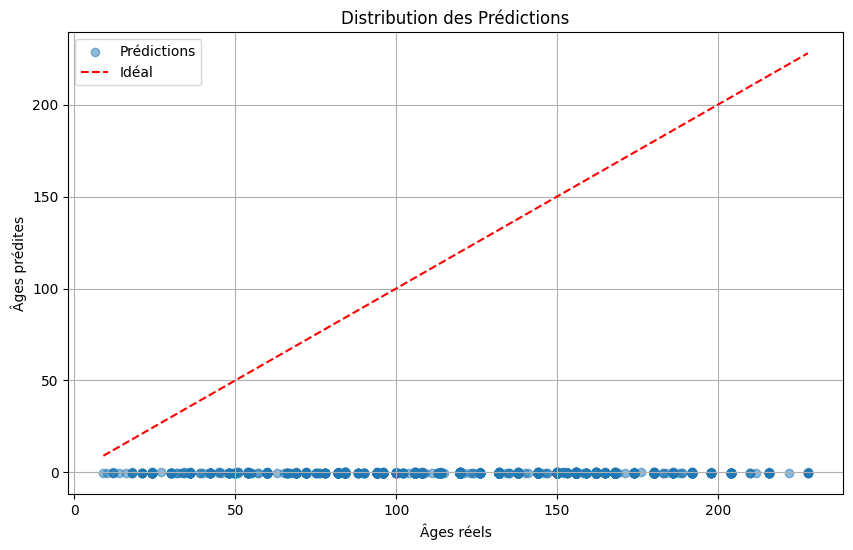

Graphique de distribution sauvegardé dans /content/drive/MyDrive/dataset-v2/checkpoints/final_prediction_distribution.png

⚙️ Réentraîner le modèle avec des couches non gelées pour améliorer les performances...
Epoch 1/10

Epoch 1: val_loss improved from inf to 1637.06946, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/fine_tuned_model_with_sex.h5


63/63 - 113s - 2s/step - loss: 2948.6707 - mae: 42.1315 - val_loss: 1637.0695 - val_mae: 33.3805 - learning_rate: 1.0000e-04
Epoch 2/10

Epoch 2: val_loss did not improve from 1637.06946
63/63 - 64s - 1s/step - loss: 1831.5389 - mae: 34.9439 - val_loss: 1825.1637 - val_mae: 36.2941 - learning_rate: 1.0000e-04
Epoch 3/10

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 3: val_loss did not improve from 1637.06946
63/63 - 34s - 533ms/step - loss: 1946.2957 - mae: 35.9866 - val_loss: 1766.0936 - val_mae: 32.0615 - learning_rate: 1.0000e-04
Epoch 4/10

Epoch 4: val_loss improved from 1637.06946 to 1517.59741, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/fine_tuned_model_with_sex.h5


63/63 - 42s - 666ms/step - loss: 1733.0831 - mae: 33.9415 - val_loss: 1517.5974 - val_mae: 31.1338 - learning_rate: 5.0000e-05
Epoch 5/10

Epoch 5: val_loss improved from 1517.59741 to 1495.69421, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/fine_tuned_model_with_sex.h5


63/63 - 45s - 721ms/step - loss: 1705.3390 - mae: 33.7893 - val_loss: 1495.6942 - val_mae: 30.6434 - learning_rate: 5.0000e-05
Epoch 6/10

Epoch 6: val_loss improved from 1495.69421 to 1446.53503, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/fine_tuned_model_with_sex.h5


63/63 - 42s - 659ms/step - loss: 1706.0327 - mae: 33.5805 - val_loss: 1446.5350 - val_mae: 30.9623 - learning_rate: 5.0000e-05
Epoch 7/10

Epoch 7: val_loss did not improve from 1446.53503
63/63 - 32s - 504ms/step - loss: 1536.2462 - mae: 31.8821 - val_loss: 1570.2867 - val_mae: 33.2845 - learning_rate: 5.0000e-05
Epoch 8/10

Epoch 8: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 8: val_loss did not improve from 1446.53503
63/63 - 32s - 507ms/step - loss: 1476.9672 - mae: 31.1185 - val_loss: 1674.4084 - val_mae: 34.4429 - learning_rate: 5.0000e-05
Epoch 9/10

Epoch 9: val_loss improved from 1446.53503 to 1201.45349, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/fine_tuned_model_with_sex.h5


63/63 - 50s - 799ms/step - loss: 1343.0747 - mae: 29.6538 - val_loss: 1201.4535 - val_mae: 27.7051 - learning_rate: 2.5000e-05
Epoch 10/10

Epoch 10: val_loss improved from 1201.45349 to 1177.33984, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/fine_tuned_model_with_sex.h5


63/63 - 82s - 1s/step - loss: 1244.5809 - mae: 28.7198 - val_loss: 1177.3398 - val_mae: 28.2166 - learning_rate: 2.5000e-05
Historique de réentraînement sauvegardé dans /content/drive/MyDrive/dataset-v2/checkpoints/fine_tune_history_with_sex.json
Graphique de réentraînement sauvegardé dans /content/drive/MyDrive/dataset-v2/checkpoints/fine_tune_training_plot_with_sex.png


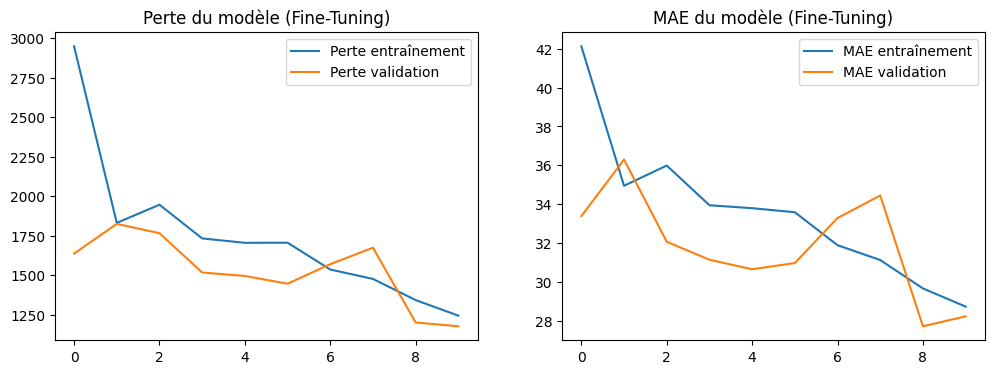

📂 Modèle final (après fine-tuning) sauvegardé dans /content/drive/MyDrive/dataset-v2/checkpoints/fine_tuned_model_with_sex.h5


In [25]:
import numpy as np
import os
import json
import gc
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow as tf

# Fonction pour construire le modèle avec entrée de sexe
def build_model_with_sex_input(trainable_base=False):
    image_input = Input(shape=(224, 224, 3), name="image_input")
    base = VGG16(weights='imagenet', include_top=False, input_tensor=image_input)

    # Rendre certaines couches de VGG16 entraînables ou non
    for layer in base.layers:
        layer.trainable = trainable_base

    x = base.output
    x = GlobalAveragePooling2D()(x)

    sex_input = Input(shape=(1,), name="sex_input")
    combined = Concatenate()([x, sex_input])
    combined = Dense(128, activation='relu')(combined)
    output = Dense(1)(combined)

    model = Model(inputs=[image_input, sex_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
    return model

# Charger le modèle final si nécessaire
checkpoint_dir = '/content/drive/MyDrive/dataset-v2/checkpoints'
final_model_path = f"{checkpoint_dir}/final_model_with_sex.h5"

if os.path.exists(final_model_path):
    print("📂 Chargement du modèle existant...")
    model = load_model(final_model_path)
else:
    print("⚙️ Construction d'un modèle neuf...")
    model = build_model_with_sex_input()

# Charger toutes les données de validation
x_val = np.load('/content/drive/MyDrive/dataset-v2/npy_files/X_val.npy') / 255.0
y_val_age = np.load('/content/drive/MyDrive/dataset-v2/npy_files/y_val_age.npy')
y_val_sex = np.load('/content/drive/MyDrive/dataset-v2/npy_files/sex_val.npy')

x_val_rgb = np.repeat(x_val, 3, axis=-1).astype(np.float32)
y_val_sex = np.expand_dims(y_val_sex, axis=-1).astype(np.float32)

# Prédictions globales
print("\n🔍 Prédiction globale des données de validation...")
global_predictions = model.predict({
    "image_input": x_val_rgb,
    "sex_input": y_val_sex
})

# Calcul des métriques globales
global_mae = mean_absolute_error(y_val_age, global_predictions)
global_mse = mean_squared_error(y_val_age, global_predictions)
print(f"\n📊 [Validation Finale] MAE: {global_mae:.4f} | MSE: {global_mse:.4f}")

# Sauvegarder les métriques dans un fichier
metrics_file = f"{checkpoint_dir}/final_metrics_with_sex.txt"
with open(metrics_file, 'w') as f:
    f.write(f"MAE: {global_mae:.4f}\n")
    f.write(f"MSE: {global_mse:.4f}\n")
print(f"Métriques sauvegardées dans {metrics_file}")

# Distribution des prédictions
plt.figure(figsize=(10, 6))
plt.scatter(y_val_age, global_predictions, alpha=0.5, label="Prédictions")
plt.plot([y_val_age.min(), y_val_age.max()], [y_val_age.min(), y_val_age.max()], 'r--', label="Idéal")
plt.xlabel("Âges réels")
plt.ylabel("Âges prédites")
plt.title("Distribution des Prédictions")
plt.legend()
plt.grid(True)
plot_distribution_file = f"{checkpoint_dir}/final_prediction_distribution.png"
plt.savefig(plot_distribution_file)
plt.show()
print(f"Graphique de distribution sauvegardé dans {plot_distribution_file}")

# Défiger et réentraîner pour améliorer les performances
print("\n⚙️ Réentraîner le modèle avec des couches non gelées pour améliorer les performances...")
model = build_model_with_sex_input(trainable_base=True)

# Callbacks pour le réentraînement
fine_tune_model_path = f"{checkpoint_dir}/fine_tuned_model_with_sex.h5"
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5, verbose=1),
    ModelCheckpoint(filepath=fine_tune_model_path, save_best_only=True, monitor='val_loss', verbose=1)
]

# Réentraîner le modèle
history = model.fit(
    {
        "image_input": x_val_rgb,
        "sex_input": y_val_sex
    },
    y_val_age,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=2
)

# Sauvegarder l'historique d'entraînement
fine_tune_history_file = f"{checkpoint_dir}/fine_tune_history_with_sex.json"
history_dict = history.history
with open(fine_tune_history_file, 'w') as f:
    json.dump(history_dict, f)
print(f"Historique de réentraînement sauvegardé dans {fine_tune_history_file}")

# Visualisation des résultats de réentraînement
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Perte entraînement')
plt.plot(history_dict['val_loss'], label='Perte validation')
plt.title('Perte du modèle (Fine-Tuning)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'], label='MAE entraînement')
plt.plot(history_dict['val_mae'], label='MAE validation')
plt.title('MAE du modèle (Fine-Tuning)')
plt.legend()

fine_tune_plot_file = f"{checkpoint_dir}/fine_tune_training_plot_with_sex.png"
plt.savefig(fine_tune_plot_file)
print(f"Graphique de réentraînement sauvegardé dans {fine_tune_plot_file}")
plt.show()

# Sauvegarder le modèle final
model.save(fine_tune_model_path)
print(f"📂 Modèle final (après fine-tuning) sauvegardé dans {fine_tune_model_path}")

⚙️ Construction d'un modèle neuf...

🔍 Prédiction globale des données de validation...
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step

📊 [Validation Finale] MAE: 128.2957 | MSE: 18211.0410
Métriques sauvegardées dans /content/drive/MyDrive/dataset-v2/checkpoints/final_metrics_with_sex.txt


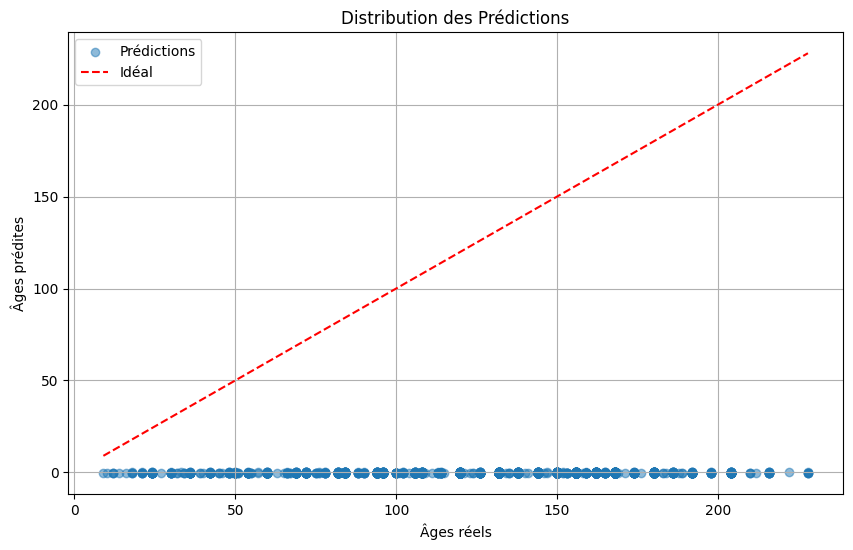

Graphique de distribution sauvegardé dans /content/drive/MyDrive/dataset-v2/checkpoints/final_prediction_distribution.png
📂 Modèle final sauvegardé dans /content/drive/MyDrive/dataset-v2/checkpoints/final_model_with_sex.h5


In [29]:
import numpy as np
import os
import json
import gc
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import MeanSquaredError

# Fonction pour construire le modèle avec entrée de sexe
def build_model_with_sex_input(trainable_base=False):
    image_input = Input(shape=(224, 224, 3), name="image_input")
    base = VGG16(weights='imagenet', include_top=False, input_tensor=image_input)

    # Rendre certaines couches de VGG16 entraînables ou non
    for layer in base.layers:
        layer.trainable = trainable_base

    x = base.output
    x = GlobalAveragePooling2D()(x)

    sex_input = Input(shape=(1,), name="sex_input")
    combined = Concatenate()([x, sex_input])
    combined = Dense(128, activation='relu')(combined)
    output = Dense(1)(combined)

    model = Model(inputs=[image_input, sex_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=[MeanSquaredError(), 'mae'])
    return model

# Répertoire des checkpoints
checkpoint_dir = '/content/drive/MyDrive/dataset-v2/checkpoints'
final_model_path = f"{checkpoint_dir}/final_model_with_sex.h5"

# Charger le modèle final
if os.path.exists(final_model_path):
    print("📂 Chargement du modèle fine-tuné existant...")
    custom_objects = {
        "mse": MeanSquaredError()  # Fournir un alias pour 'mse'
    }
    model = load_model(final_model_path, custom_objects=custom_objects)
else:
    print("⚙️ Construction d'un modèle neuf...")
    model = build_model_with_sex_input()

# Charger toutes les données de validation
x_val = np.load('/content/drive/MyDrive/dataset-v2/npy_files/X_val.npy') / 255.0
y_val_age = np.load('/content/drive/MyDrive/dataset-v2/npy_files/y_val_age.npy')
y_val_sex = np.load('/content/drive/MyDrive/dataset-v2/npy_files/sex_val.npy')

x_val_rgb = np.repeat(x_val, 3, axis=-1).astype(np.float32)
y_val_sex = np.expand_dims(y_val_sex, axis=-1).astype(np.float32)

# Prédictions globales
print("\n🔍 Prédiction globale des données de validation...")
global_predictions = model.predict({
    "image_input": x_val_rgb,
    "sex_input": y_val_sex
})

# Calcul des métriques globales
global_mae = mean_absolute_error(y_val_age, global_predictions)
global_mse = mean_squared_error(y_val_age, global_predictions)
print(f"\n📊 [Validation Finale] MAE: {global_mae:.4f} | MSE: {global_mse:.4f}")

# Sauvegarder les métriques dans un fichier
metrics_file = f"{checkpoint_dir}/final_metrics_with_sex.txt"
with open(metrics_file, 'w') as f:
    f.write(f"MAE: {global_mae:.4f}\n")
    f.write(f"MSE: {global_mse:.4f}\n")
print(f"Métriques sauvegardées dans {metrics_file}")

# Distribution des prédictions
plt.figure(figsize=(10, 6))
plt.scatter(y_val_age, global_predictions, alpha=0.5, label="Prédictions")
plt.plot([y_val_age.min(), y_val_age.max()], [y_val_age.min(), y_val_age.max()], 'r--', label="Idéal")
plt.xlabel("Âges réels")
plt.ylabel("Âges prédites")
plt.title("Distribution des Prédictions")
plt.legend()
plt.grid(True)
plot_distribution_file = f"{checkpoint_dir}/final_prediction_distribution.png"
plt.savefig(plot_distribution_file)
plt.show()
print(f"Graphique de distribution sauvegardé dans {plot_distribution_file}")

# Sauvegarder le modèle final
model.save(final_model_path)
print(f"📂 Modèle final sauvegardé dans {final_model_path}")

📂 Chargement du modèle fine-tuné existant...



⚙️ Réentraîner le modèle avec des couches partiellement dégelées...
Epoch 1/10

Epoch 1: val_loss improved from inf to 1771.22522, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/extended_fine_tuned_model_with_sex.h5


63/63 - 34s - 541ms/step - loss: 9624.7852 - mae: 82.7285 - mean_squared_error: 9624.7852 - val_loss: 1771.2252 - val_mae: 34.3113 - val_mean_squared_error: 1771.2252 - learning_rate: 1.0000e-05
Epoch 2/10

Epoch 2: val_loss improved from 1771.22522 to 1763.78210, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/extended_fine_tuned_model_with_sex.h5


63/63 - 35s - 553ms/step - loss: 1867.1128 - mae: 35.0388 - mean_squared_error: 1867.1128 - val_loss: 1763.7821 - val_mae: 34.9584 - val_mean_squared_error: 1763.7821 - learning_rate: 1.0000e-05
Epoch 3/10

Epoch 3: val_loss did not improve from 1763.78210
63/63 - 19s - 302ms/step - loss: 1769.8929 - mae: 34.3850 - mean_squared_error: 1769.8929 - val_loss: 1858.8975 - val_mae: 36.4385 - val_mean_squared_error: 1858.8975 - learning_rate: 1.0000e-05
Epoch 4/10

Epoch 4: val_loss improved from 1763.78210 to 1598.53186, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/extended_fine_tuned_model_with_sex.h5


63/63 - 26s - 412ms/step - loss: 1730.7028 - mae: 34.0299 - mean_squared_error: 1730.7028 - val_loss: 1598.5319 - val_mae: 32.7191 - val_mean_squared_error: 1598.5319 - learning_rate: 1.0000e-05
Epoch 5/10

Epoch 5: val_loss did not improve from 1598.53186
63/63 - 34s - 540ms/step - loss: 1699.4905 - mae: 33.6553 - mean_squared_error: 1699.4905 - val_loss: 1634.0610 - val_mae: 33.6741 - val_mean_squared_error: 1634.0610 - learning_rate: 1.0000e-05
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 6: val_loss did not improve from 1598.53186
63/63 - 21s - 326ms/step - loss: 1603.7443 - mae: 32.6622 - mean_squared_error: 1603.7443 - val_loss: 1649.8563 - val_mae: 30.9997 - val_mean_squared_error: 1649.8563 - learning_rate: 1.0000e-05
Epoch 7/10

Epoch 7: val_loss improved from 1598.53186 to 1382.69214, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/extended_fine_tuned_model_with_sex.h5


63/63 - 36s - 574ms/step - loss: 1559.7876 - mae: 32.3020 - mean_squared_error: 1559.7876 - val_loss: 1382.6921 - val_mae: 30.2151 - val_mean_squared_error: 1382.6921 - learning_rate: 5.0000e-06
Epoch 8/10

Epoch 8: val_loss improved from 1382.69214 to 1316.73682, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/extended_fine_tuned_model_with_sex.h5


63/63 - 40s - 640ms/step - loss: 1457.6290 - mae: 31.1564 - mean_squared_error: 1457.6290 - val_loss: 1316.7368 - val_mae: 29.5023 - val_mean_squared_error: 1316.7368 - learning_rate: 5.0000e-06
Epoch 9/10

Epoch 9: val_loss improved from 1316.73682 to 1228.16858, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/extended_fine_tuned_model_with_sex.h5


63/63 - 43s - 683ms/step - loss: 1379.5171 - mae: 30.2565 - mean_squared_error: 1379.5171 - val_loss: 1228.1686 - val_mae: 28.1841 - val_mean_squared_error: 1228.1686 - learning_rate: 5.0000e-06
Epoch 10/10

Epoch 10: val_loss improved from 1228.16858 to 1157.12671, saving model to /content/drive/MyDrive/dataset-v2/checkpoints/extended_fine_tuned_model_with_sex.h5


63/63 - 27s - 424ms/step - loss: 1301.1929 - mae: 29.2801 - mean_squared_error: 1301.1929 - val_loss: 1157.1267 - val_mae: 27.3255 - val_mean_squared_error: 1157.1267 - learning_rate: 5.0000e-06
Historique de réentraînement sauvegardé dans /content/drive/MyDrive/dataset-v2/checkpoints/extended_fine_tune_history_with_sex.json
Graphique de réentraînement sauvegardé dans /content/drive/MyDrive/dataset-v2/checkpoints/extended_fine_tune_training_plot_with_sex.png


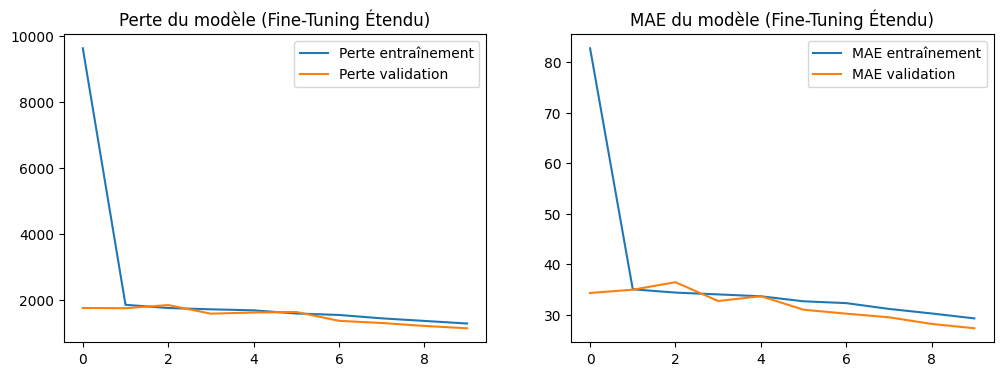


🔍 Évaluation sur l'ensemble de validation complet après extended fine-tuning...
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step


📊 [Validation Finale après Fine-Tuning Étendu] MAE: 28.0891 | MSE: 1202.2877
Métriques sauvegardées dans /content/drive/MyDrive/dataset-v2/checkpoints/extended_fine_tune_metrics_with_sex.txt
📂 Modèle final (après fine-tuning étendu) sauvegardé dans /content/drive/MyDrive/dataset-v2/checkpoints/extended_fine_tuned_model_with_sex.h5


27371

In [30]:
import numpy as np
import os
import json
import gc
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import MeanSquaredError

# Fonction pour construire le modèle avec entrée de sexe
def build_model_with_sex_input(trainable_base=False, trainable_layers=0):
    image_input = Input(shape=(224, 224, 3), name="image_input")
    base = VGG16(weights='imagenet', include_top=False, input_tensor=image_input)

    # Défiger uniquement les "trainable_layers" dernières couches
    for layer in base.layers[:-trainable_layers]:
        layer.trainable = False
    for layer in base.layers[-trainable_layers:]:
        layer.trainable = True

    x = base.output
    x = GlobalAveragePooling2D()(x)

    sex_input = Input(shape=(1,), name="sex_input")
    combined = Concatenate()([x, sex_input])
    combined = Dense(128, activation='relu')(combined)
    output = Dense(1)(combined)

    model = Model(inputs=[image_input, sex_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=[MeanSquaredError(), 'mae'])
    return model

# Répertoire des checkpoints
checkpoint_dir = '/content/drive/MyDrive/dataset-v2/checkpoints'
final_model_path = f"{checkpoint_dir}/final_model_with_sex.h5"
extended_fine_tune_model_path = f"{checkpoint_dir}/extended_fine_tuned_model_with_sex.h5"

# Charger le modèle existant
if os.path.exists(final_model_path):
    print("📂 Chargement du modèle fine-tuné existant...")
    custom_objects = {
        "mse": MeanSquaredError()  # Fournir un alias pour 'mse'
    }
    model = load_model(final_model_path, custom_objects=custom_objects)
else:
    print("⚙️ Construction d'un modèle neuf...")
    model = build_model_with_sex_input()

# Charger les données de validation
x_val = np.load('/content/drive/MyDrive/dataset-v2/npy_files/X_val.npy') / 255.0
y_val_age = np.load('/content/drive/MyDrive/dataset-v2/npy_files/y_val_age.npy')
y_val_sex = np.load('/content/drive/MyDrive/dataset-v2/npy_files/sex_val.npy')

x_val_rgb = np.repeat(x_val, 3, axis=-1).astype(np.float32)
y_val_sex = np.expand_dims(y_val_sex, axis=-1).astype(np.float32)

# Réentraîner le modèle avec dégel partiel des couches
print("\n⚙️ Réentraîner le modèle avec des couches partiellement dégelées...")
model = build_model_with_sex_input(trainable_base=True, trainable_layers=10)

# Callbacks pour réguler l'entraînement
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(patience=2, factor=0.5, verbose=1),
    ModelCheckpoint(filepath=extended_fine_tune_model_path, save_best_only=True, monitor='val_loss', verbose=1)
]

# Entraîner avec un taux d'apprentissage réduit
history = model.fit(
    {
        "image_input": x_val_rgb,
        "sex_input": y_val_sex
    },
    y_val_age,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=2
)

# Sauvegarder l'historique d'entraînement
fine_tune_history_file = f"{checkpoint_dir}/extended_fine_tune_history_with_sex.json"
history_dict = history.history
with open(fine_tune_history_file, 'w') as f:
    json.dump(history_dict, f)
print(f"Historique de réentraînement sauvegardé dans {fine_tune_history_file}")

# Visualisation des résultats
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Perte entraînement')
plt.plot(history_dict['val_loss'], label='Perte validation')
plt.title('Perte du modèle (Fine-Tuning Étendu)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'], label='MAE entraînement')
plt.plot(history_dict['val_mae'], label='MAE validation')
plt.title('MAE du modèle (Fine-Tuning Étendu)')
plt.legend()

fine_tune_plot_file = f"{checkpoint_dir}/extended_fine_tune_training_plot_with_sex.png"
plt.savefig(fine_tune_plot_file)
print(f"Graphique de réentraînement sauvegardé dans {fine_tune_plot_file}")
plt.show()

# Évaluer sur l'ensemble de validation complet
print("\n🔍 Évaluation sur l'ensemble de validation complet après extended fine-tuning...")
global_predictions = model.predict({
    "image_input": x_val_rgb,
    "sex_input": y_val_sex
})

global_mae = mean_absolute_error(y_val_age, global_predictions)
global_mse = mean_squared_error(y_val_age, global_predictions)
print(f"📊 [Validation Finale après Fine-Tuning Étendu] MAE: {global_mae:.4f} | MSE: {global_mse:.4f}")

# Sauvegarder les métriques finales dans un fichier
metrics_file = f"{checkpoint_dir}/extended_fine_tune_metrics_with_sex.txt"
with open(metrics_file, 'w') as f:
    f.write(f"MAE: {global_mae:.4f}\n")
    f.write(f"MSE: {global_mse:.4f}\n")
print(f"Métriques sauvegardées dans {metrics_file}")

# Sauvegarder le modèle final après fine-tuning étendu
model.save(extended_fine_tune_model_path)
print(f"📂 Modèle final (après fine-tuning étendu) sauvegardé dans {extended_fine_tune_model_path}")

# Libérer la mémoire après l'entraînement
gc.collect()